In [1]:
#%matplotlib notebook
%matplotlib inline
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"




Modules loaded
Reload complete
GPUs available: 1


/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [37]:
%%javascript
Jupyter.keyboard_manager.disable();
//System.out.println("disabled");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('j');
//System.out.println("remove j");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('k');
//System.out.println("remove k");

<IPython.core.display.Javascript object>

Total number of training images = 2379


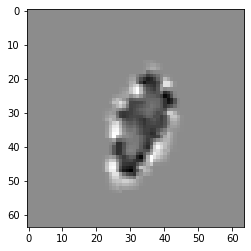

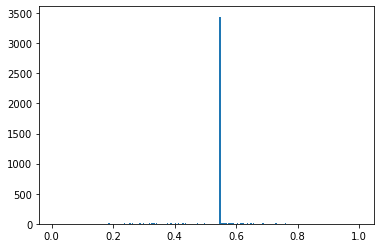

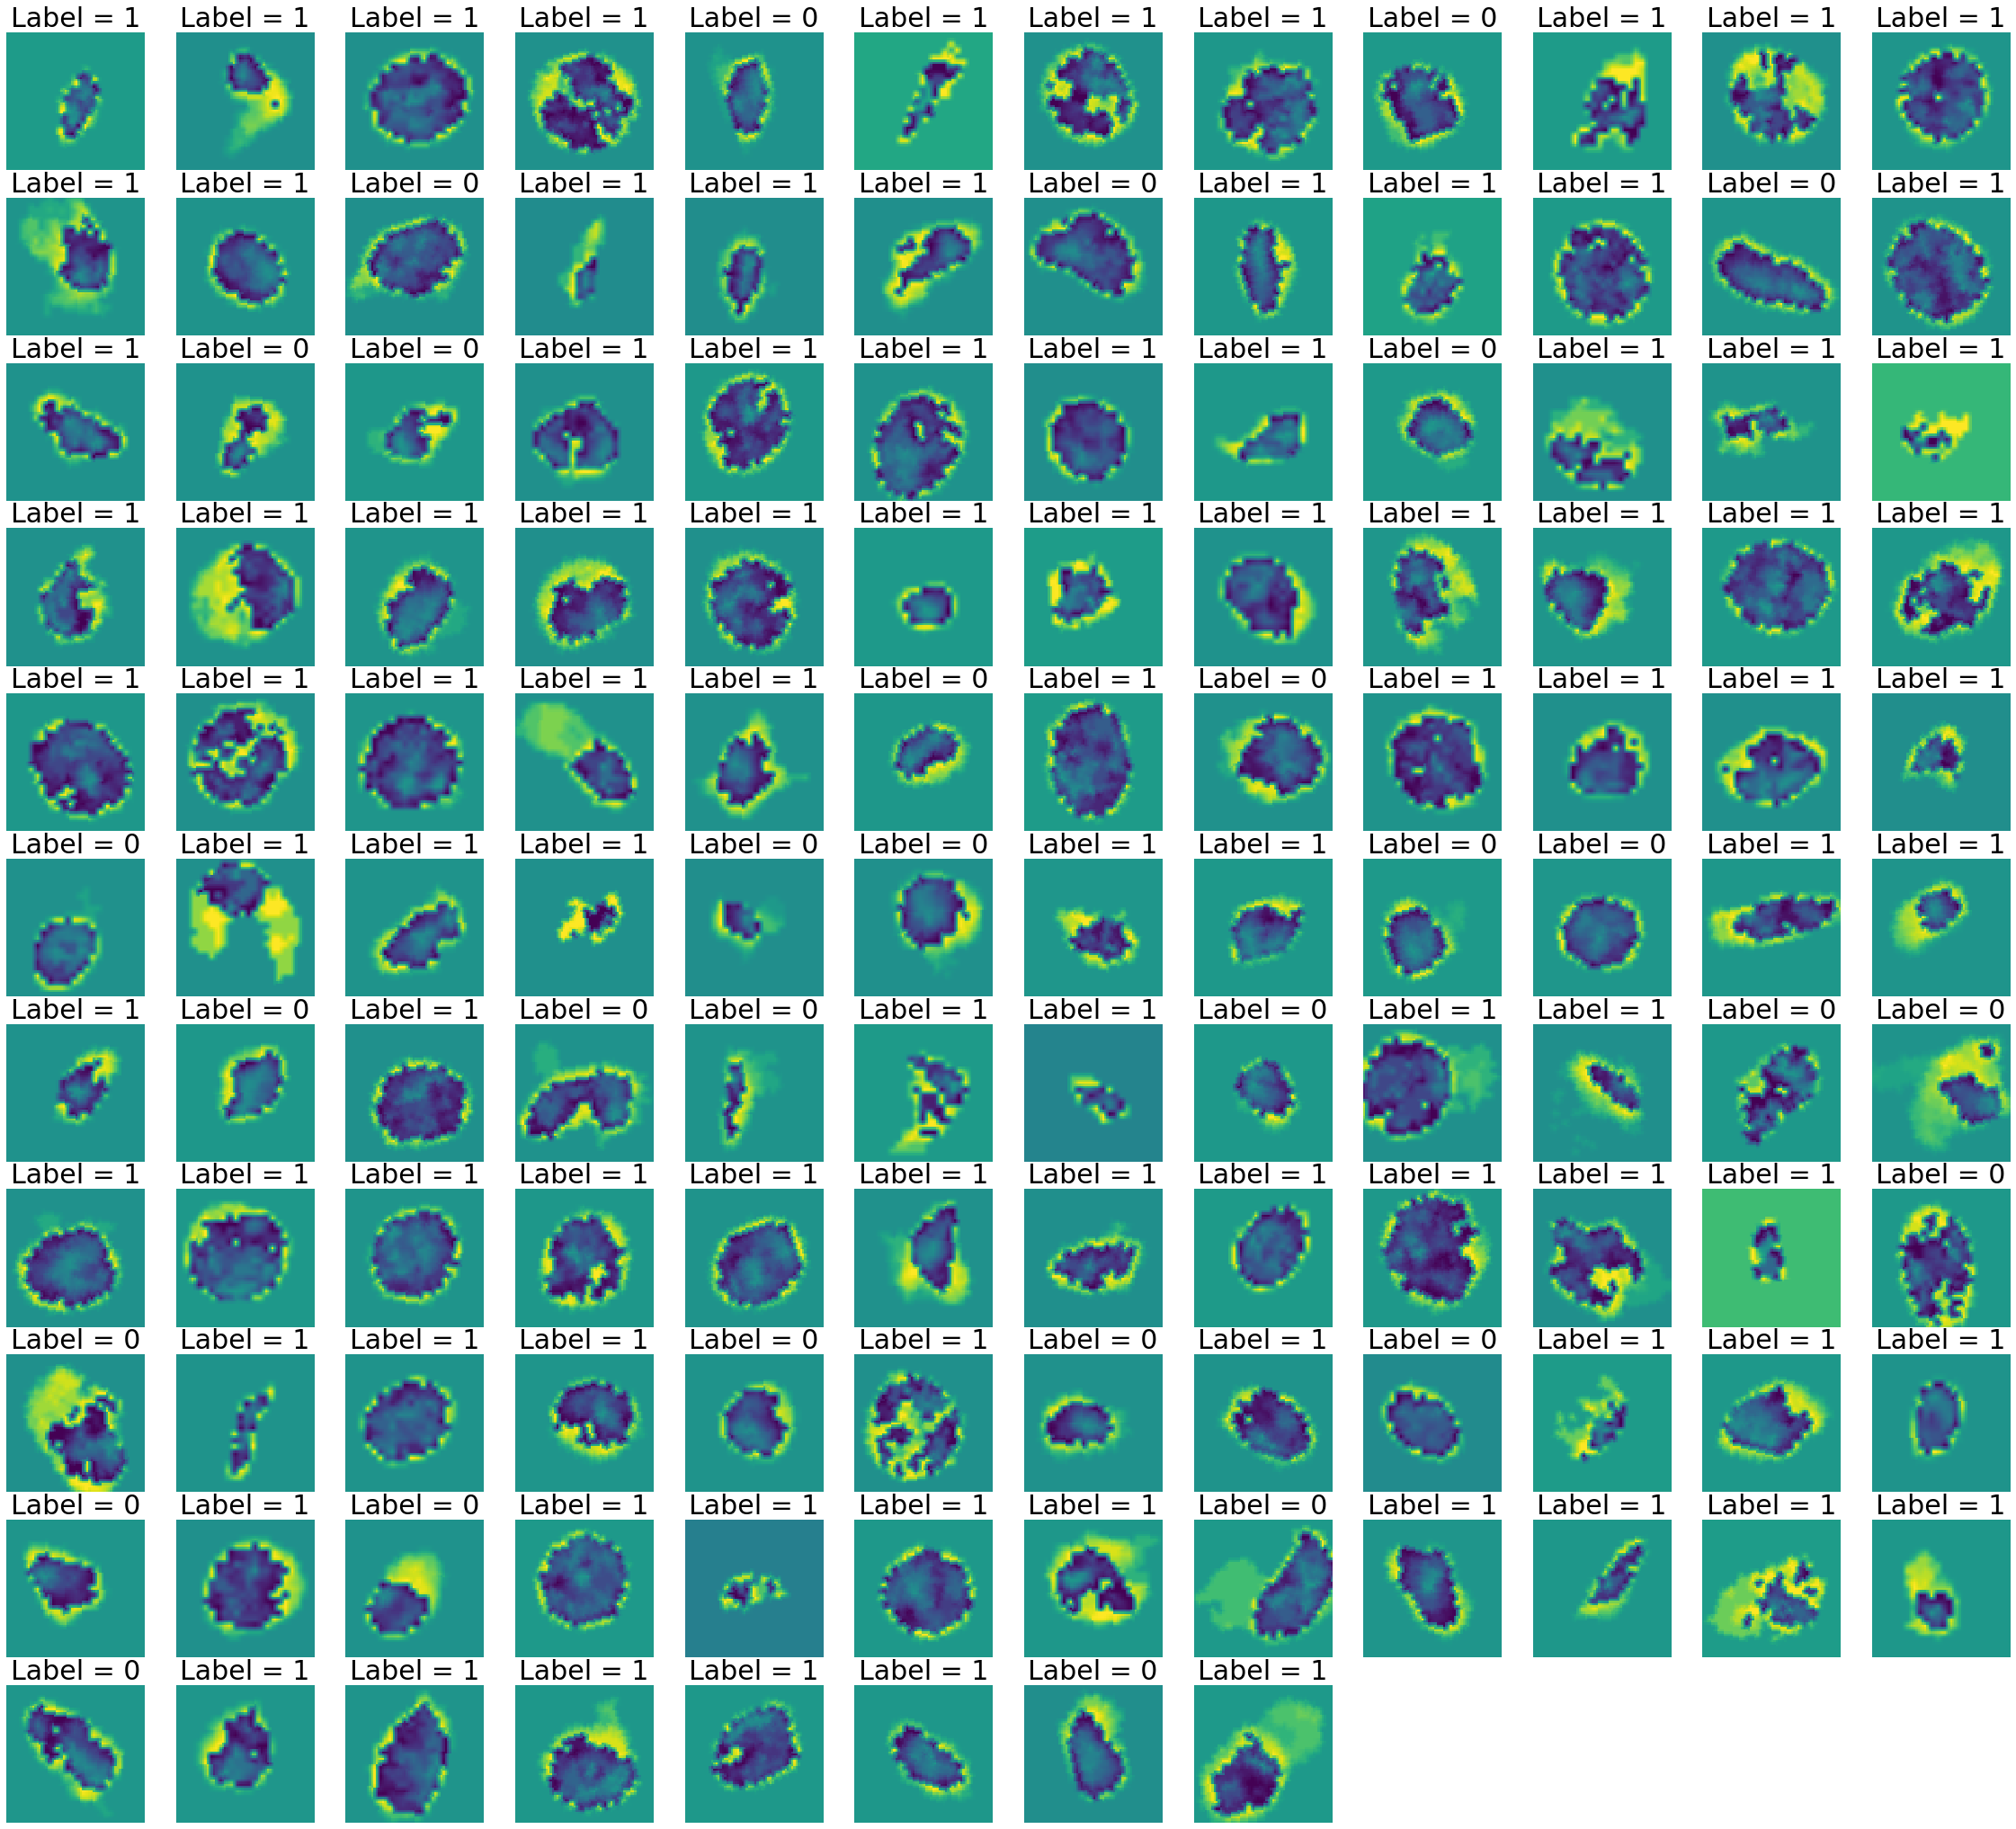

In [26]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
print("Total number of training images = " + str(data_loader.dataset.data_len))
valid_data_loader = data_loader.split_validation() #allocate some images as validation

normalized = False
util.visualizeBatch(data_loader, normalized) 

In [2]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    #torchsummary.summary(model, (1,7,32,32))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()
        a=1
    
 

In [3]:
config_file = '../configs/config_hdf5_2d.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [4]:
# Train the network
main(config, None)

Total number of training images = 2379
heatmapModel64(
  (layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): Conv2d(256, 512, k

/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
    epoch          : 1
    loss           : 1.1038897335529327
    my_metric      : 0.5859754247572816
    f1             : 0.5678154244242156
    balanced_accuracy: 0.5963893682873619
    precision      : 0.6278886426330301
    recall         : 0.5859754247572816
    val_loss       : 0.7001472115516663
    val_my_metric  : 0.3901041666666667
    val_f1         : 0.33935600947318273
    val_balanced_accuracy: 0.5619518106349145
    val_precision  : 0.727777479455196
    v

Model has not improved in -------------| 1 epochs


    epoch          : 5
    loss           : 0.5999974198639393
    my_metric      : 0.6583453428398058
    f1             : 0.6661335511321744
    balanced_accuracy: 0.6796513732743925
    precision      : 0.726785300777811
    recall         : 0.6583453428398058
    val_loss       : 0.5471014181772867
    val_my_metric  : 0.7005208333333334
    val_f1         : 0.7151425869573874
    val_balanced_accuracy: 0.6990075642650276
    val_precision  : 0.7541912042911298
    val_recall     : 0.7005208333333334
Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0628_194432/checkpoint-epoch5.pth ...
Saving current best: model_best.pth ...
    epoch          : 6
    loss           : 0.6033631078898907
    my_metric      : 0.6742832220873787
    f1             : 0.6726251871116825
    balanced_accuracy: 0.6652825660626409
    precision      : 0.7244680291607821
    recall         : 0.6742832220873787
    val_loss       : 0.5585030515988668
    val_my_metric  : 0.7333333333333334
    val_f1     

Model has not improved in -------------| 1 epochs


    epoch          : 7
    loss           : 0.5851026549935341
    my_metric      : 0.6806593219053398
    f1             : 0.6816908720106731
    balanced_accuracy: 0.6859548392627294
    precision      : 0.7371073627312529
    recall         : 0.6806593219053398
    val_loss       : 0.5594297647476196
    val_my_metric  : 0.6675
    val_f1         : 0.6826461294107498
    val_balanced_accuracy: 0.7133878981705069
    val_precision  : 0.7705739222390414
    val_recall     : 0.6675


Model has not improved in -------------| 2 epochs


    epoch          : 8
    loss           : 0.574027743190527
    my_metric      : 0.6839587757888349
    f1             : 0.6911930083430242
    balanced_accuracy: 0.7039683607395829
    precision      : 0.7442411118563975
    recall         : 0.6839587757888349
    val_loss       : 0.5586724678675333
    val_my_metric  : 0.6270833333333333
    val_f1         : 0.6410056398879013
    val_balanced_accuracy: 0.6988658586832103
    val_precision  : 0.7753224468566945
    val_recall     : 0.6270833333333333


Model has not improved in -------------| 3 epochs


    epoch          : 9
    loss           : 0.5765926614403725
    my_metric      : 0.7005461165048543
    f1             : 0.7052559205781076
    balanced_accuracy: 0.704855171115565
    precision      : 0.7475397414992052
    recall         : 0.7005461165048543
    val_loss       : 0.544490267833074
    val_my_metric  : 0.7344791666666667
    val_f1         : 0.7408887590710859
    val_balanced_accuracy: 0.7214742091319932
    val_precision  : 0.7639782046663314
    val_recall     : 0.7344791666666667
Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0628_194432/checkpoint-epoch9.pth ...
Saving current best: model_best.pth ...
    epoch          : 10
    loss           : 0.5468502677977085
    my_metric      : 0.7081974362864077
    f1             : 0.7152324225238902
    balanced_accuracy: 0.7190012682861162
    precision      : 0.7562015749345545
    recall         : 0.7081974362864077
    val_loss       : 0.5170660813649496
    val_my_metric  : 0.7210416666666667
    val_f1     

Model has not improved in -------------| 1 epochs


    epoch          : 12
    loss           : 0.5510847009718418
    my_metric      : 0.7138340033373787
    f1             : 0.7203072867977975
    balanced_accuracy: 0.7208349374748727
    precision      : 0.755892750816595
    recall         : 0.7138340033373787
    val_loss       : 0.5204456945260366
    val_my_metric  : 0.7065625
    val_f1         : 0.7199201384975343
    val_balanced_accuracy: 0.7210698033444958
    val_precision  : 0.7657367132111155
    val_recall     : 0.7065625


Model has not improved in -------------| 2 epochs


    epoch          : 13
    loss           : 0.5318432133644819
    my_metric      : 0.7329054156553398
    f1             : 0.7399175905491074
    balanced_accuracy: 0.7402044790716571
    precision      : 0.7685883294885572
    recall         : 0.7329054156553398
    val_loss       : 0.5377280414104462
    val_my_metric  : 0.7042708333333333
    val_f1         : 0.7191352062336264
    val_balanced_accuracy: 0.7519113602100921
    val_precision  : 0.7979254154111933
    val_recall     : 0.7042708333333333


Model has not improved in -------------| 3 epochs


    epoch          : 14
    loss           : 0.5322706922888756
    my_metric      : 0.7200631447208737
    f1             : 0.7276991541268198
    balanced_accuracy: 0.7324290946800901
    precision      : 0.7632905360010375
    recall         : 0.7200631447208737
    val_loss       : 0.5354012648264567
    val_my_metric  : 0.6983333333333333
    val_f1         : 0.7120110999553771
    val_balanced_accuracy: 0.7052305569078642
    val_precision  : 0.7541092870228899
    val_recall     : 0.6983333333333333


Model has not improved in -------------| 4 epochs


    epoch          : 15
    loss           : 0.5262825898826122
    my_metric      : 0.7326541641383495
    f1             : 0.7402600586951964
    balanced_accuracy: 0.7486214274352601
    precision      : 0.7752448610580949
    recall         : 0.7326541641383495
    val_loss       : 0.567261278629303
    val_my_metric  : 0.6748958333333333
    val_f1         : 0.690113635679578
    val_balanced_accuracy: 0.72195722961626
    val_precision  : 0.7854567003344926
    val_recall     : 0.6748958333333333


Model has not improved in -------------| 5 epochs


    epoch          : 16
    loss           : 0.5297149736434221
    my_metric      : 0.7365461923543689
    f1             : 0.7431100392967548
    balanced_accuracy: 0.7433948448338477
    precision      : 0.773955715676752
    recall         : 0.7365461923543689
    val_loss       : 0.5175044238567352
    val_my_metric  : 0.7503125
    val_f1         : 0.7593973986764109
    val_balanced_accuracy: 0.7473911898069202
    val_precision  : 0.7844125608631135
    val_recall     : 0.7503125


Model has not improved in -------------| 6 epochs


    epoch          : 17
    loss           : 0.5419876351952553
    my_metric      : 0.7261879930218447
    f1             : 0.7322110355711137
    balanced_accuracy: 0.7410784685763968
    precision      : 0.7765339162290237
    recall         : 0.7261879930218447
    val_loss       : 0.5611066818237305
    val_my_metric  : 0.6592708333333334
    val_f1         : 0.6716860244236749
    val_balanced_accuracy: 0.7363025211385675
    val_precision  : 0.8047240622604424
    val_recall     : 0.6592708333333334


Model has not improved in -------------| 7 epochs


    epoch          : 18
    loss           : 0.5261278599500656
    my_metric      : 0.7276386149878641
    f1             : 0.7346987894157406
    balanced_accuracy: 0.7403646572032342
    precision      : 0.7703450795723048
    recall         : 0.7276386149878641
    val_loss       : 0.518387089172999
    val_my_metric  : 0.7139583333333333
    val_f1         : 0.7271488923211525
    val_balanced_accuracy: 0.7250431509821619
    val_precision  : 0.7688701322315122
    val_recall     : 0.7139583333333333


Model has not improved in -------------| 8 epochs


    epoch          : 19
    loss           : 0.5190380997955799
    my_metric      : 0.7454822132888349
    f1             : 0.7514305547075224
    balanced_accuracy: 0.7550556225835647
    precision      : 0.7874309368914336
    recall         : 0.7454822132888349
    val_loss       : 0.5308317840099335
    val_my_metric  : 0.7799999999999999
    val_f1         : 0.7821995232343802
    val_balanced_accuracy: 0.7293411865026358
    val_precision  : 0.7854174194625924
    val_recall     : 0.7799999999999999


Model has not improved in -------------| 9 epochs


    epoch          : 20
    loss           : 0.5252477712929249
    my_metric      : 0.7485019720873787
    f1             : 0.7552800623813254
    balanced_accuracy: 0.7533568927034595
    precision      : 0.7805444755507857
    recall         : 0.7485019720873787
    val_loss       : 0.5501076380411783
    val_my_metric  : 0.6675
    val_f1         : 0.6828420827293261
    val_balanced_accuracy: 0.7321454544974664
    val_precision  : 0.7955008595719989
    val_recall     : 0.6675


Model has not improved in -------------| 10 epochs


    epoch          : 21
    loss           : 0.5133970808237791
    my_metric      : 0.7397129095873787
    f1             : 0.7457777624896544
    balanced_accuracy: 0.7463513098895062
    precision      : 0.77436234199183
    recall         : 0.7397129095873787
    val_loss       : 0.553384522596995
    val_my_metric  : 0.6997916666666667
    val_f1         : 0.7158023122710623
    val_balanced_accuracy: 0.7377502063362259
    val_precision  : 0.7921795870691066
    val_recall     : 0.6997916666666667


Model has not improved in -------------| 11 epochs


    epoch          : 22
    loss           : 0.49764223024249077
    my_metric      : 0.7430123634708737
    f1             : 0.7501192757083901
    balanced_accuracy: 0.7562175303963115
    precision      : 0.7839286970705095
    recall         : 0.7430123634708737
    val_loss       : 0.5185835957527161
    val_my_metric  : 0.7529166666666667
    val_f1         : 0.7663411307856148
    val_balanced_accuracy: 0.7662429003221841
    val_precision  : 0.8094925018086121
    val_recall     : 0.7529166666666667


Model has not improved in -------------| 12 epochs


    epoch          : 23
    loss           : 0.4978980775922537
    my_metric      : 0.7653405643203883
    f1             : 0.7710232286277658
    balanced_accuracy: 0.7691570969133235
    precision      : 0.7925858298338315
    recall         : 0.7653405643203883
    val_loss       : 0.5672308206558228
    val_my_metric  : 0.6802083333333333
    val_f1         : 0.6960611868584111
    val_balanced_accuracy: 0.7212021341053599
    val_precision  : 0.7738815555507116
    val_recall     : 0.6802083333333333


Model has not improved in -------------| 13 epochs


    epoch          : 24
    loss           : 0.511701999232173
    my_metric      : 0.7391061134708737
    f1             : 0.7466594402616935
    balanced_accuracy: 0.7548266517089467
    precision      : 0.7819752177392361
    recall         : 0.7391061134708737
    val_loss       : 0.5274378955364227
    val_my_metric  : 0.7672916666666666
    val_f1         : 0.7789087470633516
    val_balanced_accuracy: 0.7743287088740435
    val_precision  : 0.8131085477070364
    val_recall     : 0.7672916666666666


Model has not improved in -------------| 14 epochs


    epoch          : 25
    loss           : 0.5115827117115259
    my_metric      : 0.739769796723301
    f1             : 0.7463445169121905
    balanced_accuracy: 0.7471076934187467
    precision      : 0.7775137992433026
    recall         : 0.739769796723301
    val_loss       : 0.5313649475574493
    val_my_metric  : 0.7183333333333334
    val_f1         : 0.7315663753463988
    val_balanced_accuracy: 0.7608648958719183
    val_precision  : 0.8065923079554546
    val_recall     : 0.7183333333333334


Model has not improved in -------------| 15 epochs


    epoch          : 26
    loss           : 0.5126518048346043
    my_metric      : 0.7545841550364077
    f1             : 0.7611204836744369
    balanced_accuracy: 0.7636709870192024
    precision      : 0.792757739757296
    recall         : 0.7545841550364077
    val_loss       : 0.5204634070396423
    val_my_metric  : 0.738125
    val_f1         : 0.7522310130959511
    val_balanced_accuracy: 0.7624840999841002
    val_precision  : 0.8083948729422867
    val_recall     : 0.738125


Model has not improved in -------------| 16 epochs


    epoch          : 27
    loss           : 0.5016206633299589
    my_metric      : 0.7566842384708737
    f1             : 0.761716660431013
    balanced_accuracy: 0.7622144812955435
    precision      : 0.7885918834887624
    recall         : 0.7566842384708737
    val_loss       : 0.5385207335154215
    val_my_metric  : 0.7701041666666667
    val_f1         : 0.7710620727529399
    val_balanced_accuracy: 0.7239405123591528
    val_precision  : 0.7730005458634995
    val_recall     : 0.7701041666666667


Model has not improved in -------------| 17 epochs


    epoch          : 28
    loss           : 0.5059177111834288
    my_metric      : 0.7463402609223301
    f1             : 0.7527624047291137
    balanced_accuracy: 0.7567130398381853
    precision      : 0.7806143198678533
    recall         : 0.7463402609223301
    val_loss       : 0.502388060092926
    val_my_metric  : 0.74375
    val_f1         : 0.7558479781093319
    val_balanced_accuracy: 0.7692758683322367
    val_precision  : 0.8061988214373645
    val_recall     : 0.74375
Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0628_194432/checkpoint-epoch28.pth ...
Saving current best: model_best.pth ...
    epoch          : 29
    loss           : 0.49296330474317074
    my_metric      : 0.7586373634708737
    f1             : 0.7644665475969938
    balanced_accuracy: 0.766932950462855
    precision      : 0.7910630005195772
    recall         : 0.7586373634708737
    val_loss       : 0.5541762113571167
    val_my_metric  : 0.7084375
    val_f1         : 0.7220963313349132
   

Model has not improved in -------------| 1 epochs


    epoch          : 30
    loss           : 0.5103264730423689
    my_metric      : 0.7427753337378641
    f1             : 0.7491008924496148
    balanced_accuracy: 0.7583055347119894
    precision      : 0.7847192261876516
    recall         : 0.7427753337378641
    val_loss       : 0.5121642748514811
    val_my_metric  : 0.7559374999999999
    val_f1         : 0.7645963238150738
    val_balanced_accuracy: 0.7413870552808935
    val_precision  : 0.7847634870853152
    val_recall     : 0.7559374999999999


Model has not improved in -------------| 2 epochs


    epoch          : 31
    loss           : 0.49382971599698067
    my_metric      : 0.7722950166868932
    f1             : 0.7760073434255489
    balanced_accuracy: 0.7726414311371416
    precision      : 0.8014031576283906
    recall         : 0.7722950166868932
    val_loss       : 0.5258219242095947
    val_my_metric  : 0.77375
    val_f1         : 0.775403500187875
    val_balanced_accuracy: 0.7277834804150594
    val_precision  : 0.7779077736764467
    val_recall     : 0.77375


Model has not improved in -------------| 3 epochs


    epoch          : 32
    loss           : 0.4833542015403509
    my_metric      : 0.7519199408373787
    f1             : 0.7574671919086936
    balanced_accuracy: 0.7596850203879817
    precision      : 0.7865831232034743
    recall         : 0.7519199408373787
    val_loss       : 0.5478881200154623
    val_my_metric  : 0.7246874999999999
    val_f1         : 0.7383436279726006
    val_balanced_accuracy: 0.7677962642850282
    val_precision  : 0.8109436730283012
    val_recall     : 0.7246874999999999


Model has not improved in -------------| 4 epochs


    epoch          : 33
    loss           : 0.48608585074543953
    my_metric      : 0.7581348604368932
    f1             : 0.7642397511447357
    balanced_accuracy: 0.7734465134971842
    precision      : 0.796743239101864
    recall         : 0.7581348604368932
    val_loss       : 0.5242592493693033
    val_my_metric  : 0.7701041666666667
    val_f1         : 0.7732812204608526
    val_balanced_accuracy: 0.7339360477546054
    val_precision  : 0.7790316889771831
    val_recall     : 0.7701041666666667


Model has not improved in -------------| 5 epochs


    epoch          : 34
    loss           : 0.5092691406607628
    my_metric      : 0.7599979141383495
    f1             : 0.7637061618422205
    balanced_accuracy: 0.7612050353912844
    precision      : 0.795385328349945
    recall         : 0.7599979141383495
    val_loss       : 0.5315115849177042
    val_my_metric  : 0.706875
    val_f1         : 0.7209700459686269
    val_balanced_accuracy: 0.7529736459442766
    val_precision  : 0.8013324621168492
    val_recall     : 0.706875


Model has not improved in -------------| 6 epochs


    epoch          : 35
    loss           : 0.49415268562734127
    my_metric      : 0.7475111878033981
    f1             : 0.7536088170003984
    balanced_accuracy: 0.7632095211136783
    precision      : 0.7917529102819377
    recall         : 0.7475111878033981
    val_loss       : 0.5258011817932129
    val_my_metric  : 0.7329166666666667
    val_f1         : 0.7446400761150712
    val_balanced_accuracy: 0.7344057743984947
    val_precision  : 0.7774483278295463
    val_recall     : 0.7329166666666667


Model has not improved in -------------| 7 epochs


    epoch          : 36
    loss           : 0.48363377898931503
    my_metric      : 0.7638757205703883
    f1             : 0.769330518761171
    balanced_accuracy: 0.7694653715858419
    precision      : 0.7897325664668273
    recall         : 0.7638757205703883
    val_loss       : 0.5563357075055441
    val_my_metric  : 0.6871875
    val_f1         : 0.7018525442088608
    val_balanced_accuracy: 0.7459666367301366
    val_precision  : 0.7987104923433049
    val_recall     : 0.6871875


Model has not improved in -------------| 8 epochs


    epoch          : 37
    loss           : 0.48782544396817684
    my_metric      : 0.7559731492718447
    f1             : 0.7625017797936051
    balanced_accuracy: 0.7713526073086487
    precision      : 0.8019679803453217
    recall         : 0.7559731492718447
    val_loss       : 0.5166283249855042
    val_my_metric  : 0.7413541666666666
    val_f1         : 0.7541855556976659
    val_balanced_accuracy: 0.773761884674356
    val_precision  : 0.8128295736521617
    val_recall     : 0.7413541666666666


Model has not improved in -------------| 9 epochs


    epoch          : 38
    loss           : 0.5005897339433432
    my_metric      : 0.7593626744538835
    f1             : 0.7654079722557625
    balanced_accuracy: 0.766729606851557
    precision      : 0.7917811700961022
    recall         : 0.7593626744538835
    val_loss       : 0.5375618636608124
    val_my_metric  : 0.7905208333333333
    val_f1         : 0.7892503891210007
    val_balanced_accuracy: 0.737482537481446
    val_precision  : 0.7903831148369242
    val_recall     : 0.7905208333333333


Model has not improved in -------------| 10 epochs


    epoch          : 39
    loss           : 0.48205962777137756
    my_metric      : 0.7631646313713593
    f1             : 0.7692149711555644
    balanced_accuracy: 0.7718692884357969
    precision      : 0.795351447189966
    recall         : 0.7631646313713593
    val_loss       : 0.5061518053213755
    val_my_metric  : 0.7455208333333333
    val_f1         : 0.7558101143451288
    val_balanced_accuracy: 0.7505412576080178
    val_precision  : 0.7896308260698381
    val_recall     : 0.7455208333333333


Model has not improved in -------------| 11 epochs


    epoch          : 40
    loss           : 0.4745269548147917
    my_metric      : 0.7711999393203883
    f1             : 0.7763512234192474
    balanced_accuracy: 0.7741579687139662
    precision      : 0.7963421615882477
    recall         : 0.7711999393203883
    val_loss       : 0.5391332507133484
    val_my_metric  : 0.7317708333333334
    val_f1         : 0.7441522681164008
    val_balanced_accuracy: 0.7385408430002425
    val_precision  : 0.7816525169883288
    val_recall     : 0.7317708333333334


Model has not improved in -------------| 12 epochs


    epoch          : 41
    loss           : 0.4710719361901283
    my_metric      : 0.7780358768203883
    f1             : 0.7835704515220545
    balanced_accuracy: 0.7882982901494869
    precision      : 0.8077183557919928
    recall         : 0.7780358768203883
    val_loss       : 0.5135608911514282
    val_my_metric  : 0.7363541666666666
    val_f1         : 0.7491893812424095
    val_balanced_accuracy: 0.757888275199056
    val_precision  : 0.7999730044261294
    val_recall     : 0.7363541666666666


Model has not improved in -------------| 13 epochs


    epoch          : 42
    loss           : 0.45978318713605404
    my_metric      : 0.7780358768203883
    f1             : 0.7833363398439661
    balanced_accuracy: 0.7830325262422098
    precision      : 0.8017144504788423
    recall         : 0.7780358768203883
    val_loss       : 0.5467302401860555
    val_my_metric  : 0.7336458333333334
    val_f1         : 0.7443526622982617
    val_balanced_accuracy: 0.7285524113255205
    val_precision  : 0.7719507047304998
    val_recall     : 0.7336458333333334


Model has not improved in -------------| 14 epochs


    epoch          : 43
    loss           : 0.4606065545231104
    my_metric      : 0.7829044675364077
    f1             : 0.7878957362686935
    balanced_accuracy: 0.7882342655808959
    precision      : 0.8072908892650442
    recall         : 0.7829044675364077
    val_loss       : 0.5131432414054871
    val_my_metric  : 0.7556249999999999
    val_f1         : 0.7678554431819508
    val_balanced_accuracy: 0.7720827867461867
    val_precision  : 0.8089709588239886
    val_recall     : 0.7556249999999999


Model has not improved in -------------| 15 epochs


    epoch          : 44
    loss           : 0.47020438872277737
    my_metric      : 0.7702375986043689
    f1             : 0.7766282851329659
    balanced_accuracy: 0.780315501369287
    precision      : 0.8023508401691777
    recall         : 0.7702375986043689
    val_loss       : 0.5355346302191416
    val_my_metric  : 0.7273958333333334
    val_f1         : 0.7404309997868307
    val_balanced_accuracy: 0.7501222691608328
    val_precision  : 0.7899064382869613
    val_recall     : 0.7273958333333334


Model has not improved in -------------| 16 epochs


    epoch          : 45
    loss           : 0.48644525185227394
    my_metric      : 0.7603534587378641
    f1             : 0.7656217428379422
    balanced_accuracy: 0.76895616210836
    precision      : 0.7974519138580988
    recall         : 0.7603534587378641
    val_loss       : 0.5764715870221456
    val_my_metric  : 0.789375
    val_f1         : 0.7763321212811481
    val_balanced_accuracy: 0.6942934868045132
    val_precision  : 0.7781360928767643
    val_recall     : 0.789375


Model has not improved in -------------| 17 epochs


    epoch          : 46
    loss           : 0.4857062678784132
    my_metric      : 0.768360323118932
    f1             : 0.7727105248646083
    balanced_accuracy: 0.7726700695605555
    precision      : 0.7972078117536413
    recall         : 0.768360323118932
    val_loss       : 0.5051969786485037
    val_my_metric  : 0.7748958333333333
    val_f1         : 0.7835270575093095
    val_balanced_accuracy: 0.7799906498363721
    val_precision  : 0.8096833103260934
    val_recall     : 0.7748958333333333


Model has not improved in -------------| 18 epochs


    epoch          : 47
    loss           : 0.46017472073435783
    my_metric      : 0.7779031401699029
    f1             : 0.7835190686825971
    balanced_accuracy: 0.7864145802107311
    precision      : 0.8062668762911845
    recall         : 0.7779031401699029
    val_loss       : 0.561505655447642
    val_my_metric  : 0.7479166666666667
    val_f1         : 0.7559522726782854
    val_balanced_accuracy: 0.7180651894602473
    val_precision  : 0.7713487589840519
    val_recall     : 0.7479166666666668


Model has not improved in -------------| 19 epochs


    epoch          : 48
    loss           : 0.4677797742187977
    my_metric      : 0.7618040807038835
    f1             : 0.7680488087336074
    balanced_accuracy: 0.777457619626919
    precision      : 0.8013850997999991
    recall         : 0.7618040807038835
    val_loss       : 0.5526057084401449
    val_my_metric  : 0.7533333333333333
    val_f1         : 0.7586291306673307
    val_balanced_accuracy: 0.7244702665755298
    val_precision  : 0.7683798730908854
    val_recall     : 0.7533333333333333


Model has not improved in -------------| 20 epochs


    epoch          : 49
    loss           : 0.47407522052526474
    my_metric      : 0.7743524347694175
    f1             : 0.7777508727230645
    balanced_accuracy: 0.7761738697198824
    precision      : 0.801933873312553
    recall         : 0.7743524347694175
    val_loss       : 0.5658154090245565
    val_my_metric  : 0.7663541666666666
    val_f1         : 0.7634113362952765
    val_balanced_accuracy: 0.70110883268778
    val_precision  : 0.7615720072751323
    val_recall     : 0.7663541666666666


Model has not improved in -------------| 21 epochs


    epoch          : 50
    loss           : 0.44393016025424004
    my_metric      : 0.7832884557038835
    f1             : 0.7883019967371647
    balanced_accuracy: 0.7904085708547144
    precision      : 0.8116925147837154
    recall         : 0.7832884557038835
    val_loss       : 0.5241289734840393
    val_my_metric  : 0.7503125
    val_f1         : 0.7593171926585555
    val_balanced_accuracy: 0.7405318308408196
    val_precision  : 0.7838032085315231
    val_recall     : 0.7503125


Model has not improved in -------------| 22 epochs


    epoch          : 51
    loss           : 0.46103076823055744
    my_metric      : 0.7745136149878641
    f1             : 0.7791514447494712
    balanced_accuracy: 0.7791764333919399
    precision      : 0.8031862892527186
    recall         : 0.7745136149878641
    val_loss       : 0.508293867111206
    val_my_metric  : 0.7573958333333334
    val_f1         : 0.7672323007902496
    val_balanced_accuracy: 0.7646085552802925
    val_precision  : 0.8031308619335408
    val_recall     : 0.7573958333333334


Model has not improved in -------------| 23 epochs


    epoch          : 52
    loss           : 0.4583898205310106
    my_metric      : 0.7780358768203883
    f1             : 0.7841770626649146
    balanced_accuracy: 0.7893535813216195
    precision      : 0.8086020682487174
    recall         : 0.7780358768203883
    val_loss       : 0.5141954720020294
    val_my_metric  : 0.7704166666666667
    val_f1         : 0.7765887149951703
    val_balanced_accuracy: 0.7520395893871825
    val_precision  : 0.7913193797954206
    val_recall     : 0.7704166666666667


Model has not improved in -------------| 24 epochs


    epoch          : 53
    loss           : 0.43958074785768986
    my_metric      : 0.7919447815533981
    f1             : 0.7965927163170627
    balanced_accuracy: 0.7959743014860395
    precision      : 0.816939213734957
    recall         : 0.7919447815533981
    val_loss       : 0.5179197788238525
    val_my_metric  : 0.7695833333333333
    val_f1         : 0.7786977868573639
    val_balanced_accuracy: 0.7746723780101107
    val_precision  : 0.8056147596221126
    val_recall     : 0.7695833333333333


Model has not improved in -------------| 25 epochs


    epoch          : 54
    loss           : 0.4455294944345951
    my_metric      : 0.7848860361043689
    f1             : 0.7910342674922028
    balanced_accuracy: 0.7985527824178543
    precision      : 0.8166389642908641
    recall         : 0.7848860361043689
    val_loss       : 0.5606548289457957
    val_my_metric  : 0.7378125
    val_f1         : 0.7486060863037136
    val_balanced_accuracy: 0.7505039990118499
    val_precision  : 0.7839409372350602
    val_recall     : 0.7378125


Model has not improved in -------------| 26 epochs


    epoch          : 55
    loss           : 0.4399949051439762
    my_metric      : 0.7910867339199029
    f1             : 0.796155687166084
    balanced_accuracy: 0.7993061399371029
    precision      : 0.815633689720054
    recall         : 0.7910867339199029
    val_loss       : 0.5279824435710907
    val_my_metric  : 0.7475
    val_f1         : 0.7576449423783398
    val_balanced_accuracy: 0.7514783228976339
    val_precision  : 0.7883257575757575
    val_recall     : 0.7475


Model has not improved in -------------| 27 epochs


    epoch          : 56
    loss           : 0.4490748271346092
    my_metric      : 0.7846205628033981
    f1             : 0.7889403408382514
    balanced_accuracy: 0.7898553589993034
    precision      : 0.8102325827260665
    recall         : 0.7846205628033981
    val_loss       : 0.5171840886274973
    val_my_metric  : 0.72625
    val_f1         : 0.7379650732322901
    val_balanced_accuracy: 0.731445199117613
    val_precision  : 0.7734606571248137
    val_recall     : 0.72625


Model has not improved in -------------| 28 epochs


    epoch          : 57
    loss           : 0.44895057938992977
    my_metric      : 0.7856113470873787
    f1             : 0.7904991703991023
    balanced_accuracy: 0.7938476848751628
    precision      : 0.8129192638156786
    recall         : 0.7856113470873787
    val_loss       : 0.555770625670751
    val_my_metric  : 0.718125
    val_f1         : 0.7325451887683664
    val_balanced_accuracy: 0.7374216805738545
    val_precision  : 0.7834165412464152
    val_recall     : 0.718125


Model has not improved in -------------| 29 epochs


    epoch          : 58
    loss           : 0.4503331836313009
    my_metric      : 0.7941349362864077
    f1             : 0.7999032798239301
    balanced_accuracy: 0.8030333109173141
    precision      : 0.8228215899048239
    recall         : 0.7941349362864077
    val_loss       : 0.5107578039169312
    val_my_metric  : 0.7395833333333334
    val_f1         : 0.7519476047965189
    val_balanced_accuracy: 0.7739375484428673
    val_precision  : 0.8104859849651516
    val_recall     : 0.7395833333333334


Model has not improved in -------------| 30 epochs


    epoch          : 59
    loss           : 0.43479720689356327
    my_metric      : 0.7904657160194175
    f1             : 0.7960080073149622
    balanced_accuracy: 0.8053860887555637
    precision      : 0.8222163840469942
    recall         : 0.7904657160194175
    val_loss       : 0.5395245552062988
    val_my_metric  : 0.7622916666666667
    val_f1         : 0.7645058224723718
    val_balanced_accuracy: 0.723431992401137
    val_precision  : 0.770660883102457
    val_recall     : 0.7622916666666667


Model has not improved in -------------| 31 epochs


    epoch          : 60
    loss           : 0.434390664100647
    my_metric      : 0.7995202518203883
    f1             : 0.8039206303464178
    balanced_accuracy: 0.8029604858378474
    precision      : 0.819905171771057
    recall         : 0.7995202518203883
    val_loss       : 0.532269020875295
    val_my_metric  : 0.7473958333333334
    val_f1         : 0.7598472676767852
    val_balanced_accuracy: 0.769514396340239
    val_precision  : 0.8074798174912233
    val_recall     : 0.7473958333333334


Model has not improved in -------------| 32 epochs


    epoch          : 61
    loss           : 0.4418068155646324
    my_metric      : 0.7904657160194175
    f1             : 0.7959162410542495
    balanced_accuracy: 0.8031413958905216
    precision      : 0.8223122135898582
    recall         : 0.7904657160194175
    val_loss       : 0.5498387813568115
    val_my_metric  : 0.7347916666666666
    val_f1         : 0.7473604409555946
    val_balanced_accuracy: 0.7617463488699525
    val_precision  : 0.8012762791212048
    val_recall     : 0.7347916666666666


Model has not improved in -------------| 33 epochs


    epoch          : 62
    loss           : 0.43342883326113224
    my_metric      : 0.803516573118932
    f1             : 0.808002979133358
    balanced_accuracy: 0.8098145277386655
    precision      : 0.8264825418646111
    recall         : 0.803516573118932
    val_loss       : 0.5349209209283193
    val_my_metric  : 0.7154166666666667
    val_f1         : 0.7297123582061721
    val_balanced_accuracy: 0.7516529117793302
    val_precision  : 0.7958610355693834
    val_recall     : 0.7154166666666667


Model has not improved in -------------| 34 epochs


    epoch          : 63
    loss           : 0.43779629841446877
    my_metric      : 0.7875644720873787
    f1             : 0.7925312169590844
    balanced_accuracy: 0.7922941319305871
    precision      : 0.8107871095367082
    recall         : 0.7875644720873787
    val_loss       : 0.5096475680669149
    val_my_metric  : 0.761875
    val_f1         : 0.77322982981878
    val_balanced_accuracy: 0.7834480685793155
    val_precision  : 0.8197545702224199
    val_recall     : 0.761875


Model has not improved in -------------| 35 epochs


    epoch          : 64
    loss           : 0.4305969551205635
    my_metric      : 0.7987807190533981
    f1             : 0.8029903570387459
    balanced_accuracy: 0.805289783654717
    precision      : 0.8237672524769961
    recall         : 0.7987807190533981
    val_loss       : 0.5758516391118368
    val_my_metric  : 0.6928125
    val_f1         : 0.7098488217820322
    val_balanced_accuracy: 0.7401666607952276
    val_precision  : 0.7932806178791246
    val_recall     : 0.6928125


Model has not improved in -------------| 36 epochs


    epoch          : 65
    loss           : 0.4413386154919863
    my_metric      : 0.7851088440533981
    f1             : 0.7907399624633579
    balanced_accuracy: 0.8013175511397339
    precision      : 0.8194516987427309
    recall         : 0.7851088440533981
    val_loss       : 0.5628846287727356
    val_my_metric  : 0.7596875000000001
    val_f1         : 0.7618942200882809
    val_balanced_accuracy: 0.711502364133943
    val_precision  : 0.7649213920217209
    val_recall     : 0.7596875000000001


Model has not improved in -------------| 37 epochs


    epoch          : 66
    loss           : 0.4462349899113178
    my_metric      : 0.7890293158373787
    f1             : 0.7935711915683786
    balanced_accuracy: 0.788778467480531
    precision      : 0.8122333676929125
    recall         : 0.7890293158373787
    val_loss       : 0.5217054784297943
    val_my_metric  : 0.7556249999999999
    val_f1         : 0.7644075248180915
    val_balanced_accuracy: 0.7546952391686484
    val_precision  : 0.7893781138042991
    val_recall     : 0.7556249999999999


Model has not improved in -------------| 38 epochs


    epoch          : 67
    loss           : 0.42589330300688744
    my_metric      : 0.7960738395024272
    f1             : 0.801297601540681
    balanced_accuracy: 0.806725327219486
    precision      : 0.823918159113358
    recall         : 0.7960738395024272
    val_loss       : 0.5281960169474283
    val_my_metric  : 0.7340625
    val_f1         : 0.7474896969071264
    val_balanced_accuracy: 0.756918030602241
    val_precision  : 0.797452489749075
    val_recall     : 0.7340625


Model has not improved in -------------| 39 epochs


    epoch          : 68
    loss           : 0.42773693427443504
    my_metric      : 0.7890150940533981
    f1             : 0.7942059204128289
    balanced_accuracy: 0.7987944461490857
    precision      : 0.816123672842721
    recall         : 0.7890150940533981
    val_loss       : 0.5568908751010895
    val_my_metric  : 0.7430208333333334
    val_f1         : 0.750845466667835
    val_balanced_accuracy: 0.7065329045017381
    val_precision  : 0.7665918278769842
    val_recall     : 0.7430208333333334


Model has not improved in -------------| 40 epochs


    epoch          : 69
    loss           : 0.4230757523328066
    my_metric      : 0.8035450166868932
    f1             : 0.8082342562304369
    balanced_accuracy: 0.8111719976955771
    precision      : 0.8285272436456574
    recall         : 0.8035450166868932
    val_loss       : 0.5322032769521078
    val_my_metric  : 0.7607291666666667
    val_f1         : 0.7699955595592541
    val_balanced_accuracy: 0.7624698244848434
    val_precision  : 0.796725970209223
    val_recall     : 0.7607291666666667


Model has not improved in -------------| 41 epochs


    epoch          : 70
    loss           : 0.40644134022295475
    my_metric      : 0.8117272830703883
    f1             : 0.8170445226025386
    balanced_accuracy: 0.8217044064376218
    precision      : 0.8396924346976622
    recall         : 0.8117272830703883
    val_loss       : 0.5628199279308319
    val_my_metric  : 0.7259375
    val_f1         : 0.7387184974687383
    val_balanced_accuracy: 0.7659819787979082
    val_precision  : 0.8072695435856151
    val_recall     : 0.7259375


Model has not improved in -------------| 42 epochs


    epoch          : 71
    loss           : 0.41094972006976604
    my_metric      : 0.8036777533373787
    f1             : 0.8088458161565097
    balanced_accuracy: 0.8139573224262946
    precision      : 0.8338828394064974
    recall         : 0.8036777533373787
    val_loss       : 0.5403927663962046
    val_my_metric  : 0.761875
    val_f1         : 0.7669278127403129
    val_balanced_accuracy: 0.732075943716722
    val_precision  : 0.7755650517782872
    val_recall     : 0.761875


Model has not improved in -------------| 43 epochs


    epoch          : 72
    loss           : 0.4203826040029526
    my_metric      : 0.8012363470873787
    f1             : 0.8064190196821635
    balanced_accuracy: 0.8155594257608919
    precision      : 0.8330255946446735
    recall         : 0.8012363470873787
    val_loss       : 0.5603236357371012
    val_my_metric  : 0.7678125000000001
    val_f1         : 0.7670002845804521
    val_balanced_accuracy: 0.7099030817177061
    val_precision  : 0.7680093070512838
    val_recall     : 0.7678125000000001


Model has not improved in -------------| 44 epochs


    epoch          : 73
    loss           : 0.41556585021317005
    my_metric      : 0.8088118173543689
    f1             : 0.8132338452364059
    balanced_accuracy: 0.817641145013494
    precision      : 0.8331789448531137
    recall         : 0.8088118173543689
    val_loss       : 0.554023265838623
    val_my_metric  : 0.7392708333333333
    val_f1         : 0.7506913681991608
    val_balanced_accuracy: 0.7632146092096029
    val_precision  : 0.8018471648716957
    val_recall     : 0.7392708333333333


Model has not improved in -------------| 45 epochs


    epoch          : 74
    loss           : 0.4179082214832306
    my_metric      : 0.8090204035194175
    f1             : 0.8134753159380498
    balanced_accuracy: 0.8174621418143496
    precision      : 0.832539918344377
    recall         : 0.8090204035194175
    val_loss       : 0.516105850537618
    val_my_metric  : 0.7845833333333333
    val_f1         : 0.7915799598857495
    val_balanced_accuracy: 0.7781422296836579
    val_precision  : 0.8115355057481423
    val_recall     : 0.7845833333333333


Model has not improved in -------------| 46 epochs


    epoch          : 75
    loss           : 0.4120473340153694
    my_metric      : 0.8033079869538835
    f1             : 0.8085385003844778
    balanced_accuracy: 0.8146960055900228
    precision      : 0.8294703660540018
    recall         : 0.8033079869538835
    val_loss       : 0.6473849614461263
    val_my_metric  : 0.6619791666666667
    val_f1         : 0.6768909746559867
    val_balanced_accuracy: 0.7201051272645413
    val_precision  : 0.7804728152578146
    val_recall     : 0.6619791666666667


Model has not improved in -------------| 47 epochs


    epoch          : 76
    loss           : 0.41827994026243687
    my_metric      : 0.8039005612864077
    f1             : 0.808698299695843
    balanced_accuracy: 0.8139738090289368
    precision      : 0.8333925633310564
    recall         : 0.8039005612864077
    val_loss       : 0.6001376807689667
    val_my_metric  : 0.7916666666666666
    val_f1         : 0.7861661870976088
    val_balanced_accuracy: 0.7278666951244116
    val_precision  : 0.7856036668079401
    val_recall     : 0.7916666666666666


Model has not improved in -------------| 48 epochs


    epoch          : 77
    loss           : 0.4215127732604742
    my_metric      : 0.7996529884708737
    f1             : 0.8034706050150876
    balanced_accuracy: 0.8063541439186005
    precision      : 0.8265688246985279
    recall         : 0.7996529884708737
    val_loss       : 0.6037037670612335
    val_my_metric  : 0.7596875000000001
    val_f1         : 0.7622980110392081
    val_balanced_accuracy: 0.7151843872088669
    val_precision  : 0.766373103332373
    val_recall     : 0.7596875000000001


Model has not improved in -------------| 49 epochs


    epoch          : 78
    loss           : 0.4247966054826975
    my_metric      : 0.7967375227548543
    f1             : 0.8017690168867262
    balanced_accuracy: 0.8089865829991414
    precision      : 0.8276368700830301
    recall         : 0.7967375227548543
    val_loss       : 0.7044878204663595
    val_my_metric  : 0.6345833333333334
    val_f1         : 0.6498000837478058
    val_balanced_accuracy: 0.7153362058095185
    val_precision  : 0.7911049739173587
    val_recall     : 0.6345833333333334


Model has not improved in -------------| 50 epochs


    epoch          : 79
    loss           : 0.4077400006353855
    my_metric      : 0.8099685224514563
    f1             : 0.8144163854254612
    balanced_accuracy: 0.8227582955695523
    precision      : 0.8403251128779562
    recall         : 0.8099685224514563
    val_loss       : 0.5454381704330444
    val_my_metric  : 0.7801041666666667
    val_f1         : 0.7762324292948023
    val_balanced_accuracy: 0.7073211439458266
    val_precision  : 0.7737932857891584
    val_recall     : 0.7801041666666667


Model has not improved in -------------| 51 epochs


    epoch          : 80
    loss           : 0.4248690642416477
    my_metric      : 0.8018289214199029
    f1             : 0.8066587265169143
    balanced_accuracy: 0.8108876197520118
    precision      : 0.8265142719714359
    recall         : 0.8018289214199029
    val_loss       : 0.5592047075430552
    val_my_metric  : 0.7191666666666666
    val_f1         : 0.7344103956373832
    val_balanced_accuracy: 0.7446333667047446
    val_precision  : 0.7899089068991829
    val_recall     : 0.7191666666666666


Model has not improved in -------------| 52 epochs


    epoch          : 81
    loss           : 0.3983338885009289
    my_metric      : 0.8125568871359223
    f1             : 0.8172539294279983
    balanced_accuracy: 0.8262175292247639
    precision      : 0.8396994699536964
    recall         : 0.8125568871359223
    val_loss       : 0.5117081602414449
    val_my_metric  : 0.7465625
    val_f1         : 0.7568358316687691
    val_balanced_accuracy: 0.7438140308063436
    val_precision  : 0.7838914312410509
    val_recall     : 0.7465625


Model has not improved in -------------| 53 epochs


    epoch          : 82
    loss           : 0.40045295655727386
    my_metric      : 0.8125853307038835
    f1             : 0.8166160508151779
    balanced_accuracy: 0.8207242750592416
    precision      : 0.835771923794328
    recall         : 0.8125853307038835
    val_loss       : 0.5738357702891032
    val_my_metric  : 0.7525
    val_f1         : 0.7595426900456531
    val_balanced_accuracy: 0.7280979544525943
    val_precision  : 0.7755301079866297
    val_recall     : 0.7525


Model has not improved in -------------| 54 epochs


    epoch          : 83
    loss           : 0.3955981321632862
    my_metric      : 0.8089161104368932
    f1             : 0.8128744143487499
    balanced_accuracy: 0.8155315470948136
    precision      : 0.8317303955886349
    recall         : 0.8089161104368932
    val_loss       : 0.5500116149584452
    val_my_metric  : 0.718125
    val_f1         : 0.7323017180574816
    val_balanced_accuracy: 0.7522260056456442
    val_precision  : 0.7953040992278432
    val_recall     : 0.718125


Model has not improved in -------------| 55 epochs


    epoch          : 84
    loss           : 0.38870986737310886
    my_metric      : 0.8176909511529126
    f1             : 0.8221017873846952
    balanced_accuracy: 0.8292848663832693
    precision      : 0.8419324423021926
    recall         : 0.8176909511529126
    val_loss       : 0.5500885943571726
    val_my_metric  : 0.7770833333333332
    val_f1         : 0.7729200589922677
    val_balanced_accuracy: 0.7007402444825871
    val_precision  : 0.7717348146446025
    val_recall     : 0.7770833333333332


Model has not improved in -------------| 56 epochs


    epoch          : 85
    loss           : 0.3948008343577385
    my_metric      : 0.8108550136529126
    f1             : 0.8155552945706622
    balanced_accuracy: 0.8218111341685026
    precision      : 0.8367248117816634
    recall         : 0.8108550136529126
    val_loss       : 0.5693096021811167
    val_my_metric  : 0.7359375
    val_f1         : 0.7480831458028351
    val_balanced_accuracy: 0.7657626369001581
    val_precision  : 0.8008726937348212
    val_recall     : 0.7359375


Model has not improved in -------------| 57 epochs


    epoch          : 86
    loss           : 0.4013852681964636
    my_metric      : 0.8110019720873787
    f1             : 0.8152795794421961
    balanced_accuracy: 0.818621880810611
    precision      : 0.8367113542331814
    recall         : 0.8110019720873787
    val_loss       : 0.5546980202198029
    val_my_metric  : 0.731875
    val_f1         : 0.7431819837244772
    val_balanced_accuracy: 0.7457058676669929
    val_precision  : 0.7812645057256126
    val_recall     : 0.731875


Model has not improved in -------------| 58 epochs


    epoch          : 87
    loss           : 0.40477134846150875
    my_metric      : 0.8041518128033981
    f1             : 0.8086072952688748
    balanced_accuracy: 0.8121136949973732
    precision      : 0.8283283998486395
    recall         : 0.8041518128033981
    val_loss       : 0.535465677579244
    val_my_metric  : 0.7592708333333333
    val_f1         : 0.7661263764320506
    val_balanced_accuracy: 0.7381350679737776
    val_precision  : 0.780058704679225
    val_recall     : 0.7592708333333333


Model has not improved in -------------| 59 epochs


    epoch          : 88
    loss           : 0.37806062400341034
    my_metric      : 0.8290541565533981
    f1             : 0.8331676448749741
    balanced_accuracy: 0.8388125606289557
    precision      : 0.8502269099513432
    recall         : 0.8290541565533981
    val_loss       : 0.5715446670850118
    val_my_metric  : 0.78375
    val_f1         : 0.7839897198182082
    val_balanced_accuracy: 0.7342388167388169
    val_precision  : 0.7845945314901059
    val_recall     : 0.78375


Model has not improved in -------------| 60 epochs


    epoch          : 89
    loss           : 0.38403211906552315
    my_metric      : 0.815723604368932
    f1             : 0.8192823741433913
    balanced_accuracy: 0.821377757773959
    precision      : 0.8371403317383895
    recall         : 0.815723604368932
    val_loss       : 0.6396790941556295
    val_my_metric  : 0.7009374999999999
    val_f1         : 0.716105318377329
    val_balanced_accuracy: 0.7282208230858184
    val_precision  : 0.77600086500107
    val_recall     : 0.7009374999999999


Model has not improved in -------------| 61 epochs


    epoch          : 90
    loss           : 0.409061249345541
    my_metric      : 0.8020943947208737
    f1             : 0.8075529190506259
    balanced_accuracy: 0.8185465954829443
    precision      : 0.8361238024971981
    recall         : 0.8020943947208737
    val_loss       : 0.5688767433166504
    val_my_metric  : 0.7740625
    val_f1         : 0.7798225422056498
    val_balanced_accuracy: 0.7508063475921704
    val_precision  : 0.791433211675876
    val_recall     : 0.7740625


Model has not improved in -------------| 62 epochs


    epoch          : 91
    loss           : 0.3881247080862522
    my_metric      : 0.8123340791868932
    f1             : 0.8162131888078302
    balanced_accuracy: 0.8192556889816855
    precision      : 0.8351613890771006
    recall         : 0.8123340791868932
    val_loss       : 0.5503564774990082
    val_my_metric  : 0.7785416666666666
    val_f1         : 0.783191821618152
    val_balanced_accuracy: 0.7439814601530772
    val_precision  : 0.7910060710958672
    val_recall     : 0.7785416666666666


Model has not improved in -------------| 63 epochs


    epoch          : 92
    loss           : 0.40508151426911354
    my_metric      : 0.8131921268203883
    f1             : 0.816565697535882
    balanced_accuracy: 0.8165238638658726
    precision      : 0.8361424418454372
    recall         : 0.8131921268203883
    val_loss       : 0.5295331279436747
    val_my_metric  : 0.7663541666666666
    val_f1         : 0.7704075821019263
    val_balanced_accuracy: 0.741438594109067
    val_precision  : 0.7846012327858545
    val_recall     : 0.7663541666666666


Model has not improved in -------------| 64 epochs


    epoch          : 93
    loss           : 0.38814267702400684
    my_metric      : 0.8174396996359223
    f1             : 0.8218449330238905
    balanced_accuracy: 0.8288218978393249
    precision      : 0.8416864744022002
    recall         : 0.8174396996359223
    val_loss       : 0.5640169580777487
    val_my_metric  : 0.75375
    val_f1         : 0.7642468660096844
    val_balanced_accuracy: 0.7644615705942365
    val_precision  : 0.7983765819277792
    val_recall     : 0.75375


Model has not improved in -------------| 65 epochs


    epoch          : 94
    loss           : 0.3867598846554756
    my_metric      : 0.8117130612864077
    f1             : 0.8159507438158468
    balanced_accuracy: 0.8252645186794554
    precision      : 0.8415831692516847
    recall         : 0.8117130612864077
    val_loss       : 0.5777216156323751
    val_my_metric  : 0.7507291666666666
    val_f1         : 0.7556622711148866
    val_balanced_accuracy: 0.7218712817397028
    val_precision  : 0.7674580312984953
    val_recall     : 0.7507291666666666


Model has not improved in -------------| 66 epochs


    epoch          : 95
    loss           : 0.37752862088382244
    my_metric      : 0.8245411104368932
    f1             : 0.8283828915113538
    balanced_accuracy: 0.8316085727897623
    precision      : 0.8462291288468952
    recall         : 0.8245411104368932
    val_loss       : 0.5501592953999838
    val_my_metric  : 0.7158333333333333
    val_f1         : 0.7300410600050103
    val_balanced_accuracy: 0.7536931134370444
    val_precision  : 0.7949913643150177
    val_recall     : 0.7158333333333333


Model has not improved in -------------| 67 epochs


    epoch          : 96
    loss           : 0.37794728949666023
    my_metric      : 0.823047823118932
    f1             : 0.8265724418887052
    balanced_accuracy: 0.8300888273701436
    precision      : 0.8448504048768009
    recall         : 0.823047823118932
    val_loss       : 0.5671645104885101
    val_my_metric  : 0.7600000000000001
    val_f1         : 0.7570794870555199
    val_balanced_accuracy: 0.6866379093831626
    val_precision  : 0.7599357691079182
    val_recall     : 0.7600000000000001


Model has not improved in -------------| 68 epochs


    epoch          : 97
    loss           : 0.3886060584336519
    my_metric      : 0.8183261908373787
    f1             : 0.8221158914754478
    balanced_accuracy: 0.8216849470214516
    precision      : 0.8386713198691512
    recall         : 0.8183261908373787
    val_loss       : 0.5763677358627319
    val_my_metric  : 0.7763541666666667
    val_f1         : 0.7819970329463922
    val_balanced_accuracy: 0.7664683099450035
    val_precision  : 0.8014926597736071
    val_recall     : 0.7763541666666667


Model has not improved in -------------| 69 epochs


    epoch          : 98
    loss           : 0.38598746433854103
    my_metric      : 0.8213459496359223
    f1             : 0.8247614063863478
    balanced_accuracy: 0.825118573918815
    precision      : 0.8398138032698799
    recall         : 0.8213459496359223
    val_loss       : 0.6585495074590048
    val_my_metric  : 0.6761458333333333
    val_f1         : 0.6943156235962943
    val_balanced_accuracy: 0.7313851918690628
    val_precision  : 0.792744270363028
    val_recall     : 0.6761458333333333


Model has not improved in -------------| 70 epochs


    epoch          : 99
    loss           : 0.37111187167465687
    my_metric      : 0.8217299378033981
    f1             : 0.8267580576524476
    balanced_accuracy: 0.8379982626957583
    precision      : 0.8543789391387677
    recall         : 0.8217299378033981
    val_loss       : 0.6296333074569702
    val_my_metric  : 0.7875
    val_f1         : 0.7814690250020561
    val_balanced_accuracy: 0.714650681823862
    val_precision  : 0.7790466510859829
    val_recall     : 0.7875


Model has not improved in -------------| 71 epochs


    epoch          : 100
    loss           : 0.38753366470336914
    my_metric      : 0.8255034511529126
    f1             : 0.827691339674856
    balanced_accuracy: 0.8256789946074425
    precision      : 0.8456754387161751
    recall         : 0.8255034511529126
    val_loss       : 0.5305342674255371
    val_my_metric  : 0.7692708333333332
    val_f1         : 0.777105910436326
    val_balanced_accuracy: 0.7608233335055585
    val_precision  : 0.7966407425746088
    val_recall     : 0.7692708333333332


Model has not improved in -------------| 72 epochs


Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0628_194432/checkpoint-epoch100.pth ...
    epoch          : 101
    loss           : 0.35941206850111485
    my_metric      : 0.8281961089199029
    f1             : 0.832428715253691
    balanced_accuracy: 0.839938173746034
    precision      : 0.8506110312821555
    recall         : 0.8281961089199029
    val_loss       : 0.5810427765051523
    val_my_metric  : 0.7359375
    val_f1         : 0.748793618590826
    val_balanced_accuracy: 0.7602739783194116
    val_precision  : 0.7988559661643388
    val_recall     : 0.7359375


Model has not improved in -------------| 73 epochs


    epoch          : 102
    loss           : 0.3577977381646633
    my_metric      : 0.8317325925364077
    f1             : 0.8356460714146374
    balanced_accuracy: 0.8410631959588437
    precision      : 0.853504050983885
    recall         : 0.8317325925364077
    val_loss       : 0.5470357537269592
    val_my_metric  : 0.7447916666666666
    val_f1         : 0.7543354129877221
    val_balanced_accuracy: 0.7396255474290955
    val_precision  : 0.7784938289587999
    val_recall     : 0.7447916666666666


Model has not improved in -------------| 74 epochs


    epoch          : 103
    loss           : 0.3414288740605116
    my_metric      : 0.8472106341019418
    f1             : 0.8510084496520353
    balanced_accuracy: 0.8614962862323264
    precision      : 0.8691619097868073
    recall         : 0.8472106341019418
    val_loss       : 0.5984834035237631
    val_my_metric  : 0.7251041666666667
    val_f1         : 0.7374727940618394
    val_balanced_accuracy: 0.7371547555758081
    val_precision  : 0.7797574291676184
    val_recall     : 0.7251041666666667


Model has not improved in -------------| 75 epochs


    epoch          : 104
    loss           : 0.34250357653945684
    my_metric      : 0.848926729368932
    f1             : 0.8523399609558282
    balanced_accuracy: 0.8586833978274315
    precision      : 0.8670802203038246
    recall         : 0.848926729368932
    val_loss       : 0.5781741738319397
    val_my_metric  : 0.7529166666666667
    val_f1         : 0.7629149321082745
    val_balanced_accuracy: 0.7582356105387001
    val_precision  : 0.7926932962795642
    val_recall     : 0.7529166666666667


Model has not improved in -------------| 76 epochs


    epoch          : 105
    loss           : 0.3343634344637394
    my_metric      : 0.8498890700849515
    f1             : 0.8533999315762224
    balanced_accuracy: 0.8618937709422486
    precision      : 0.8704041242494223
    recall         : 0.8498890700849515
    val_loss       : 0.5566275914510092
    val_my_metric  : 0.7575
    val_f1         : 0.7639464596913146
    val_balanced_accuracy: 0.7376188249961041
    val_precision  : 0.777585193452381
    val_recall     : 0.7575


Model has not improved in -------------| 77 epochs


    epoch          : 106
    loss           : 0.34007974341511726
    my_metric      : 0.8535582903519418
    f1             : 0.8570276047364157
    balanced_accuracy: 0.8634205679262394
    precision      : 0.8728198490724216
    recall         : 0.8535582903519418
    val_loss       : 0.5981680750846863
    val_my_metric  : 0.7463541666666668
    val_f1         : 0.7550020150494211
    val_balanced_accuracy: 0.7335400553354713
    val_precision  : 0.7747641786462918
    val_recall     : 0.7463541666666668


Model has not improved in -------------| 78 epochs


    epoch          : 107
    loss           : 0.33816379122436047
    my_metric      : 0.8419864987864077
    f1             : 0.8461809577040181
    balanced_accuracy: 0.8563198298160952
    precision      : 0.8655820931801068
    recall         : 0.8419864987864077
    val_loss       : 0.5608315269152323
    val_my_metric  : 0.761875
    val_f1         : 0.7708348838501616
    val_balanced_accuracy: 0.7635241098763892
    val_precision  : 0.7971673435277996
    val_recall     : 0.761875


Model has not improved in -------------| 79 epochs


    epoch          : 108
    loss           : 0.34118908643722534
    my_metric      : 0.8399290807038835
    f1             : 0.8437187314399538
    balanced_accuracy: 0.8505824501943317
    precision      : 0.8610111177643518
    recall         : 0.8399290807038835
    val_loss       : 0.5166339576244354
    val_my_metric  : 0.7577083333333333
    val_f1         : 0.7693845025194174
    val_balanced_accuracy: 0.7770685238608254
    val_precision  : 0.811820259424639
    val_recall     : 0.7577083333333333


Model has not improved in -------------| 80 epochs


    epoch          : 109
    loss           : 0.3242048714309931
    my_metric      : 0.8624943112864077
    f1             : 0.8654868866144096
    balanced_accuracy: 0.8731429124178198
    precision      : 0.8800374313426463
    recall         : 0.8624943112864077
    val_loss       : 0.5398828585942587
    val_my_metric  : 0.7521875000000001
    val_f1         : 0.7613267530702018
    val_balanced_accuracy: 0.7504700055496918
    val_precision  : 0.7890868566334007
    val_recall     : 0.7521875000000001


Model has not improved in -------------| 81 epochs


    epoch          : 110
    loss           : 0.3265190590173006
    my_metric      : 0.8550373558859223
    f1             : 0.8587511965793544
    balanced_accuracy: 0.8686272896674664
    precision      : 0.8764381785941983
    recall         : 0.8550373558859223
    val_loss       : 0.5822081367174784
    val_my_metric  : 0.7722916666666667
    val_f1         : 0.778929342478774
    val_balanced_accuracy: 0.7588932830171459
    val_precision  : 0.7957908152780675
    val_recall     : 0.7722916666666667


Model has not improved in -------------| 82 epochs


    epoch          : 111
    loss           : 0.3313727332279086
    my_metric      : 0.8391468825849515
    f1             : 0.8431579523408314
    balanced_accuracy: 0.849101145269995
    precision      : 0.8598619988526913
    recall         : 0.8391468825849515
    val_loss       : 0.565124382575353
    val_my_metric  : 0.7563541666666667
    val_f1         : 0.7656748547328639
    val_balanced_accuracy: 0.7592641284129479
    val_precision  : 0.7951563750039843
    val_recall     : 0.7563541666666667


Model has not improved in -------------| 83 epochs


    epoch          : 112
    loss           : 0.3322107885032892
    my_metric      : 0.8466038379854369
    f1             : 0.8509195431395976
    balanced_accuracy: 0.8545770487329526
    precision      : 0.868016686033527
    recall         : 0.8466038379854369
    val_loss       : 0.5666116873423258
    val_my_metric  : 0.7621875
    val_f1         : 0.768842705196083
    val_balanced_accuracy: 0.7442518755982991
    val_precision  : 0.7865777889847729
    val_recall     : 0.7621875


Model has not improved in -------------| 84 epochs


    epoch          : 113
    loss           : 0.32689964212477207
    my_metric      : 0.8513823574029126
    f1             : 0.8547888144847295
    balanced_accuracy: 0.8624013035638357
    precision      : 0.8706749847665712
    recall         : 0.8513823574029126
    val_loss       : 0.6056660612424215
    val_my_metric  : 0.7556249999999999
    val_f1         : 0.7622618677383914
    val_balanced_accuracy: 0.7350965542269717
    val_precision  : 0.7796858383804587
    val_recall     : 0.7556249999999999


Model has not improved in -------------| 85 epochs


    epoch          : 114
    loss           : 0.34054870158433914
    my_metric      : 0.8418822057038835
    f1             : 0.8449291760809143
    balanced_accuracy: 0.8457243200984006
    precision      : 0.8582445931967448
    recall         : 0.8418822057038835
    val_loss       : 0.57780322432518
    val_my_metric  : 0.7463541666666668
    val_f1         : 0.7589912827693867
    val_balanced_accuracy: 0.7636366080973206
    val_precision  : 0.8026635980285595
    val_recall     : 0.7463541666666668


Model has not improved in -------------| 86 epochs


    epoch          : 115
    loss           : 0.3129573231562972
    my_metric      : 0.8472248558859223
    f1             : 0.850842573810939
    balanced_accuracy: 0.8602278798214295
    precision      : 0.8695875200268635
    recall         : 0.8472248558859223
    val_loss       : 0.5402455727259318
    val_my_metric  : 0.7827083333333333
    val_f1         : 0.7861778127906646
    val_balanced_accuracy: 0.7436739027207616
    val_precision  : 0.792504738823848
    val_recall     : 0.7827083333333333


Model has not improved in -------------| 87 epochs


    epoch          : 116
    loss           : 0.3179742619395256
    my_metric      : 0.8543262666868932
    f1             : 0.857864347385684
    balanced_accuracy: 0.8652228203343826
    precision      : 0.8739516053611945
    recall         : 0.8543262666868932
    val_loss       : 0.5837472975254059
    val_my_metric  : 0.7463541666666668
    val_f1         : 0.7558703536073331
    val_balanced_accuracy: 0.7413769927989243
    val_precision  : 0.7799072503641639
    val_recall     : 0.7463541666666668


Model has not improved in -------------| 88 epochs


    epoch          : 117
    loss           : 0.33578069508075714
    my_metric      : 0.844532198118932
    f1             : 0.8483082139733428
    balanced_accuracy: 0.8564369848968016
    precision      : 0.8651245897537087
    recall         : 0.844532198118932
    val_loss       : 0.5263482729593912
    val_my_metric  : 0.7492708333333334
    val_f1         : 0.7590777730349817
    val_balanced_accuracy: 0.7517206753040439
    val_precision  : 0.7869849243484319
    val_recall     : 0.7492708333333334


Model has not improved in -------------| 89 epochs


    epoch          : 118
    loss           : 0.32755662873387337
    my_metric      : 0.8523731416868932
    f1             : 0.8555623419615691
    balanced_accuracy: 0.8636912663669001
    precision      : 0.8732025309804988
    recall         : 0.8523731416868932
    val_loss       : 0.5728359222412109
    val_my_metric  : 0.7436458333333333
    val_f1         : 0.7488904033426671
    val_balanced_accuracy: 0.7112447305626719
    val_precision  : 0.7611747743504237
    val_recall     : 0.7436458333333333


Model has not improved in -------------| 90 epochs


    epoch          : 119
    loss           : 0.3407481200993061
    my_metric      : 0.8391468825849515
    f1             : 0.8432294171005503
    balanced_accuracy: 0.8514505909806515
    precision      : 0.8616687713475225
    recall         : 0.8391468825849515
    val_loss       : 0.5800459186236063
    val_my_metric  : 0.7447916666666666
    val_f1         : 0.7559048211844429
    val_balanced_accuracy: 0.748425345408104
    val_precision  : 0.7885502193470705
    val_recall     : 0.7447916666666666


Model has not improved in -------------| 91 epochs


    epoch          : 120
    loss           : 0.33836863189935684
    my_metric      : 0.8458927487864077
    f1             : 0.8494986394701113
    balanced_accuracy: 0.8575652177113964
    precision      : 0.865891775574782
    recall         : 0.8458927487864077
    val_loss       : 0.5493027865886688
    val_my_metric  : 0.7473958333333334
    val_f1         : 0.7565247333631678
    val_balanced_accuracy: 0.7441901060536197
    val_precision  : 0.7845523218086203
    val_recall     : 0.7473958333333334


Model has not improved in -------------| 92 epochs


    epoch          : 121
    loss           : 0.32189472019672394
    my_metric      : 0.8546675895024272
    f1             : 0.8577964599989306
    balanced_accuracy: 0.8623250107177131
    precision      : 0.8711833956897264
    recall         : 0.8546675895024272
    val_loss       : 0.5409876008828481
    val_my_metric  : 0.7922916666666667
    val_f1         : 0.7988753810073437
    val_balanced_accuracy: 0.7890872493046407
    val_precision  : 0.8202872162326695
    val_recall     : 0.7922916666666667


Model has not improved in -------------| 93 epochs


    epoch          : 122
    loss           : 0.3200894072651863
    my_metric      : 0.8524632129854369
    f1             : 0.8558571013864722
    balanced_accuracy: 0.8639186571911376
    precision      : 0.872004687756873
    recall         : 0.8524632129854369
    val_loss       : 0.568323016166687
    val_my_metric  : 0.7533333333333333
    val_f1         : 0.7607672202521804
    val_balanced_accuracy: 0.7317755979833024
    val_precision  : 0.7753648352085852
    val_recall     : 0.7533333333333333


Model has not improved in -------------| 94 epochs


    epoch          : 123
    loss           : 0.3107143631204963
    my_metric      : 0.854297823118932
    f1             : 0.8574098631743884
    balanced_accuracy: 0.86513695590587
    precision      : 0.8729030490941073
    recall         : 0.854297823118932
    val_loss       : 0.6533507704734802
    val_my_metric  : 0.7759375
    val_f1         : 0.77669243392655
    val_balanced_accuracy: 0.7281562367817628
    val_precision  : 0.7794324721442321
    val_recall     : 0.7759375


Model has not improved in -------------| 95 epochs


    epoch          : 124
    loss           : 0.32520973589271307
    my_metric      : 0.8584411028519418
    f1             : 0.8610810041254979
    balanced_accuracy: 0.8625540064386088
    precision      : 0.8712622656038898
    recall         : 0.8584411028519418
    val_loss       : 0.5374374787012736
    val_my_metric  : 0.7647916666666666
    val_f1         : 0.7758653638046483
    val_balanced_accuracy: 0.7842632076341508
    val_precision  : 0.8200146969132183
    val_recall     : 0.7647916666666666


Model has not improved in -------------| 96 epochs


    epoch          : 125
    loss           : 0.3125650966539979
    my_metric      : 0.8662536028519418
    f1             : 0.8693175515967919
    balanced_accuracy: 0.8790573353442148
    precision      : 0.8842442110372728
    recall         : 0.8662536028519418
    val_loss       : 0.5840620398521423
    val_my_metric  : 0.7949999999999999
    val_f1         : 0.7965867987969012
    val_balanced_accuracy: 0.7562629890665944
    val_precision  : 0.8005601291553304
    val_recall     : 0.7949999999999999


Model has not improved in -------------| 97 epochs


    epoch          : 126
    loss           : 0.31396735552698374
    my_metric      : 0.8508940761529126
    f1             : 0.8545551858399569
    balanced_accuracy: 0.8634267693857575
    precision      : 0.8715801338830482
    recall         : 0.8508940761529126
    val_loss       : 0.552197645107905
    val_my_metric  : 0.7481249999999999
    val_f1         : 0.7604492408215539
    val_balanced_accuracy: 0.7626505571145158
    val_precision  : 0.8019846557314451
    val_recall     : 0.7481249999999999


Model has not improved in -------------| 98 epochs


    epoch          : 127
    loss           : 0.3087145071476698
    my_metric      : 0.8649072739684466
    f1             : 0.867941664143594
    balanced_accuracy: 0.8770625864043688
    precision      : 0.8820973325046478
    recall         : 0.8649072739684466
    val_loss       : 0.5644199053446451
    val_my_metric  : 0.7775
    val_f1         : 0.7844500278560492
    val_balanced_accuracy: 0.767646683061009
    val_precision  : 0.8010142283234631
    val_recall     : 0.7775


Model has not improved in -------------| 99 epochs


    epoch          : 128
    loss           : 0.3211990939453244
    my_metric      : 0.8497989987864077
    f1             : 0.8533105353024214
    balanced_accuracy: 0.8617591809887564
    precision      : 0.870709838532598
    recall         : 0.8497989987864077
    val_loss       : 0.6078419287999471
    val_my_metric  : 0.7692708333333332
    val_f1         : 0.7726046325528371
    val_balanced_accuracy: 0.7342819337166203
    val_precision  : 0.7784004174980899
    val_recall     : 0.7692708333333332


Model has not improved in -------------| 100 epochs


    epoch          : 129
    loss           : 0.3198235835880041
    my_metric      : 0.8491779808859223
    f1             : 0.8529709046980551
    balanced_accuracy: 0.8614317570287904
    precision      : 0.8702988886267958
    recall         : 0.8491779808859223
    val_loss       : 0.5964689453442892
    val_my_metric  : 0.7633333333333333
    val_f1         : 0.7723322183428393
    val_balanced_accuracy: 0.7633495848082102
    val_precision  : 0.7978664582890377
    val_recall     : 0.7633333333333333


Model has not improved in -------------| 101 epochs


    epoch          : 130
    loss           : 0.30519030150026083
    my_metric      : 0.8612522754854369
    f1             : 0.864039634609309
    balanced_accuracy: 0.8671204247607931
    precision      : 0.8765798712838002
    recall         : 0.8612522754854369
    val_loss       : 0.5664045214653015
    val_my_metric  : 0.73
    val_f1         : 0.7407279245062544
    val_balanced_accuracy: 0.7287878398125228
    val_precision  : 0.7709610889499761
    val_recall     : 0.73


Model has not improved in -------------| 102 epochs


    epoch          : 131
    loss           : 0.3062873650342226
    my_metric      : 0.8612380537014563
    f1             : 0.8644792074081221
    balanced_accuracy: 0.8740433804408956
    precision      : 0.8804156821086495
    recall         : 0.8612380537014563
    val_loss       : 0.563305675983429
    val_my_metric  : 0.7678125000000001
    val_f1         : 0.7745005798494464
    val_balanced_accuracy: 0.7568700872950189
    val_precision  : 0.7939017602921963
    val_recall     : 0.7678125000000001


Model has not improved in -------------| 103 epochs


    epoch          : 132
    loss           : 0.3122200397774577
    my_metric      : 0.8497989987864077
    f1             : 0.8537114745907576
    balanced_accuracy: 0.8649743040235187
    precision      : 0.8738850997797767
    recall         : 0.8497989987864077
    val_loss       : 0.5622908274332682
    val_my_metric  : 0.7608333333333333
    val_f1         : 0.7688641970269945
    val_balanced_accuracy: 0.7552440652085469
    val_precision  : 0.7901190199564904
    val_recall     : 0.7608333333333333


Model has not improved in -------------| 104 epochs


    epoch          : 133
    loss           : 0.3005654253065586
    my_metric      : 0.8667561058859223
    f1             : 0.8690701735567709
    balanced_accuracy: 0.8732085555645327
    precision      : 0.8804367744403808
    recall         : 0.8667561058859223
    val_loss       : 0.542282780011495
    val_my_metric  : 0.7614583333333332
    val_f1         : 0.7714907472781141
    val_balanced_accuracy: 0.7572205781875718
    val_precision  : 0.7976158088334389
    val_recall     : 0.7614583333333332


Model has not improved in -------------| 105 epochs


    epoch          : 134
    loss           : 0.31201301887631416
    my_metric      : 0.8585738395024272
    f1             : 0.8618255676887127
    balanced_accuracy: 0.8684753232257413
    precision      : 0.876053687220248
    recall         : 0.8585738395024272
    val_loss       : 0.5679134130477905
    val_my_metric  : 0.7607291666666667
    val_f1         : 0.7709663777553742
    val_balanced_accuracy: 0.771800627063785
    val_precision  : 0.8037052451065568
    val_recall     : 0.7607291666666667


Model has not improved in -------------| 106 epochs


    epoch          : 135
    loss           : 0.3057288182899356
    my_metric      : 0.8643004778519418
    f1             : 0.867189140403231
    balanced_accuracy: 0.874764197649019
    precision      : 0.881021863164663
    recall         : 0.8643004778519418
    val_loss       : 0.5903469721476237
    val_my_metric  : 0.7711458333333333
    val_f1         : 0.7757654834602056
    val_balanced_accuracy: 0.7424963344068923
    val_precision  : 0.7839406634746923
    val_recall     : 0.7711458333333333


Model has not improved in -------------| 107 epochs


    epoch          : 136
    loss           : 0.29638352058827877
    my_metric      : 0.8682067278519418
    f1             : 0.8711420106335581
    balanced_accuracy: 0.8782665401750998
    precision      : 0.8854271799436672
    recall         : 0.8682067278519418
    val_loss       : 0.5853354732195536
    val_my_metric  : 0.7340625
    val_f1         : 0.7441596078249018
    val_balanced_accuracy: 0.7299002309467809
    val_precision  : 0.7706602012993765
    val_recall     : 0.7340625


Model has not improved in -------------| 108 epochs


    epoch          : 137
    loss           : 0.3037135247141123
    my_metric      : 0.8618590716019418
    f1             : 0.8649208799709369
    balanced_accuracy: 0.8718022439665835
    precision      : 0.8785779762435417
    recall         : 0.8618590716019418
    val_loss       : 0.6037944356600443
    val_my_metric  : 0.7280208333333333
    val_f1         : 0.7394089078603455
    val_balanced_accuracy: 0.7402964728182454
    val_precision  : 0.7824739392124012
    val_recall     : 0.7280208333333333


Model has not improved in -------------| 109 epochs


    epoch          : 138
    loss           : 0.30910078436136246
    my_metric      : 0.8525817278519418
    f1             : 0.8560099566082067
    balanced_accuracy: 0.865470628827759
    precision      : 0.8730614149866124
    recall         : 0.8525817278519418
    val_loss       : 0.5754855573177338
    val_my_metric  : 0.7711458333333333
    val_f1         : 0.7767880282168647
    val_balanced_accuracy: 0.7453709241538188
    val_precision  : 0.7886364907245443
    val_recall     : 0.7711458333333333


Model has not improved in -------------| 110 epochs


    epoch          : 139
    loss           : 0.31118960306048393
    my_metric      : 0.8627171192354369
    f1             : 0.8657271336808405
    balanced_accuracy: 0.8704870632647455
    precision      : 0.878587818904168
    recall         : 0.8627171192354369
    val_loss       : 0.6016574700673422
    val_my_metric  : 0.7533333333333333
    val_f1         : 0.7613537123529609
    val_balanced_accuracy: 0.7412987822524989
    val_precision  : 0.7803133012820513
    val_recall     : 0.7533333333333333


Model has not improved in -------------| 111 epochs


    epoch          : 140
    loss           : 0.2912268713116646
    my_metric      : 0.8651585254854369
    f1             : 0.8682708658177722
    balanced_accuracy: 0.877381642923067
    precision      : 0.8824482552727483
    recall         : 0.8651585254854369
    val_loss       : 0.5824405550956726
    val_my_metric  : 0.7470833333333333
    val_f1         : 0.7551641904167585
    val_balanced_accuracy: 0.7283364344355795
    val_precision  : 0.7728632826307882
    val_recall     : 0.7470833333333333


Model has not improved in -------------| 112 epochs


    epoch          : 141
    loss           : 0.31135963648557663
    my_metric      : 0.8584695464199029
    f1             : 0.8613429417179443
    balanced_accuracy: 0.8670249877719117
    precision      : 0.8740330443524742
    recall         : 0.8584695464199029
    val_loss       : 0.6062061389287313
    val_my_metric  : 0.7351041666666666
    val_f1         : 0.7470866859020974
    val_balanced_accuracy: 0.7422758349111603
    val_precision  : 0.7833393779494786
    val_recall     : 0.7351041666666666


Model has not improved in -------------| 113 epochs


    epoch          : 142
    loss           : 0.2977198902517557
    my_metric      : 0.8541935300364077
    f1             : 0.8570736462395667
    balanced_accuracy: 0.8645983349691083
    precision      : 0.8737694073334921
    recall         : 0.8541935300364077
    val_loss       : 0.5968368450800577
    val_my_metric  : 0.771875
    val_f1         : 0.7768883712025542
    val_balanced_accuracy: 0.7488809466337557
    val_precision  : 0.7886442945300568
    val_recall     : 0.771875


Model has not improved in -------------| 114 epochs


    epoch          : 143
    loss           : 0.2988680237904191
    my_metric      : 0.8527144645024272
    f1             : 0.8565900131713959
    balanced_accuracy: 0.8663880199184335
    precision      : 0.8742540360190715
    recall         : 0.8527144645024272
    val_loss       : 0.5932844877243042
    val_my_metric  : 0.7782291666666667
    val_f1         : 0.7828210078040249
    val_balanced_accuracy: 0.745136731161868
    val_precision  : 0.7907622234904615
    val_recall     : 0.7782291666666667


Model has not improved in -------------| 115 epochs


    epoch          : 144
    loss           : 0.2992910584434867
    my_metric      : 0.8652912621359223
    f1             : 0.8679608645095149
    balanced_accuracy: 0.8750448831926824
    precision      : 0.881442190367258
    recall         : 0.8652912621359223
    val_loss       : 0.6234140992164612
    val_my_metric  : 0.7521875000000001
    val_f1         : 0.7587113846459395
    val_balanced_accuracy: 0.7311110346928902
    val_precision  : 0.7736817956349208
    val_recall     : 0.7521875000000001


Model has not improved in -------------| 116 epochs


    epoch          : 145
    loss           : 0.30647298600524664
    my_metric      : 0.8580713364684466
    f1             : 0.8612102094692476
    balanced_accuracy: 0.8665553938242065
    precision      : 0.8742130195715995
    recall         : 0.8580713364684466
    val_loss       : 0.5731700658798218
    val_my_metric  : 0.7567708333333334
    val_f1         : 0.7663458304620224
    val_balanced_accuracy: 0.7559874103352365
    val_precision  : 0.7964879562479615
    val_recall     : 0.7567708333333334


Model has not improved in -------------| 117 epochs


    epoch          : 146
    loss           : 0.2969431793317199
    my_metric      : 0.874317354368932
    f1             : 0.876839035588665
    balanced_accuracy: 0.8814870710713696
    precision      : 0.8871387075827578
    recall         : 0.874317354368932
    val_loss       : 0.6121353507041931
    val_my_metric  : 0.7310416666666667
    val_f1         : 0.7441272365863029
    val_balanced_accuracy: 0.7472024698148294
    val_precision  : 0.7872801517737879
    val_recall     : 0.7310416666666667


Model has not improved in -------------| 118 epochs


    epoch          : 147
    loss           : 0.28502278216183186
    my_metric      : 0.8663863395024272
    f1             : 0.8693499789953437
    balanced_accuracy: 0.8789269512285128
    precision      : 0.8854451155005628
    recall         : 0.8663863395024272
    val_loss       : 0.6116473277409872
    val_my_metric  : 0.7853125
    val_f1         : 0.7886224977399202
    val_balanced_accuracy: 0.7532645170378575
    val_precision  : 0.7956427999920841
    val_recall     : 0.7853125


Model has not improved in -------------| 119 epochs


    epoch          : 148
    loss           : 0.2961638867855072
    my_metric      : 0.8710036787014563
    f1             : 0.8737851269520814
    balanced_accuracy: 0.8818848938883395
    precision      : 0.8872880411362615
    recall         : 0.8710036787014563
    val_loss       : 0.607671837011973
    val_my_metric  : 0.7634374999999999
    val_f1         : 0.767677877565394
    val_balanced_accuracy: 0.7380659847876331
    val_precision  : 0.7780063502126436
    val_recall     : 0.7634374999999999


Model has not improved in -------------| 120 epochs


    epoch          : 149
    loss           : 0.30649489536881447
    my_metric      : 0.8544163379854369
    f1             : 0.8580477787477133
    balanced_accuracy: 0.8668603583439143
    precision      : 0.8749823835716115
    recall         : 0.8544163379854369
    val_loss       : 0.5538301169872284
    val_my_metric  : 0.7569791666666666
    val_f1         : 0.7620482875870457
    val_balanced_accuracy: 0.7227530986178898
    val_precision  : 0.770955691638477
    val_recall     : 0.7569791666666666


Model has not improved in -------------| 121 epochs


    epoch          : 150
    loss           : 0.3030700869858265
    my_metric      : 0.8685764942354369
    f1             : 0.8709922123714313
    balanced_accuracy: 0.8762835707756356
    precision      : 0.8833775896245372
    recall         : 0.8685764942354369
    val_loss       : 0.5927771329879761
    val_my_metric  : 0.7372916666666667
    val_f1         : 0.7490719691455846
    val_balanced_accuracy: 0.753262795866875
    val_precision  : 0.7912307562737159
    val_recall     : 0.7372916666666667


Model has not improved in -------------| 122 epochs


    epoch          : 151
    loss           : 0.30276101268827915
    my_metric      : 0.8612522754854369
    f1             : 0.8641152998323451
    balanced_accuracy: 0.8703287139845208
    precision      : 0.8770627654945787
    recall         : 0.8612522754854369
    val_loss       : 0.577759325504303
    val_my_metric  : 0.7288541666666667
    val_f1         : 0.7422088081671415
    val_balanced_accuracy: 0.7345459489265836
    val_precision  : 0.7810662073857246
    val_recall     : 0.7288541666666667


Model has not improved in -------------| 123 epochs


    epoch          : 152
    loss           : 0.29648304358124733
    my_metric      : 0.8712833737864077
    f1             : 0.8744620710402409
    balanced_accuracy: 0.8853124497055346
    precision      : 0.8899147458365111
    recall         : 0.8712833737864077
    val_loss       : 0.6043118437131246
    val_my_metric  : 0.7307291666666668
    val_f1         : 0.7434844770616048
    val_balanced_accuracy: 0.7550897853953881
    val_precision  : 0.7935147892943409
    val_recall     : 0.7307291666666668


Model has not improved in -------------| 124 epochs


    epoch          : 153
    loss           : 0.29739426355808973
    my_metric      : 0.857715791868932
    f1             : 0.8607348689086934
    balanced_accuracy: 0.8671428300815395
    precision      : 0.8765309364790628
    recall         : 0.857715791868932
    val_loss       : 0.6120134790738424
    val_my_metric  : 0.7648958333333334
    val_f1         : 0.7697405940483505
    val_balanced_accuracy: 0.7290411165795913
    val_precision  : 0.7786051414199128
    val_recall     : 0.7648958333333334


Model has not improved in -------------| 125 epochs


    epoch          : 154
    loss           : 0.2995890034362674
    my_metric      : 0.8466038379854369
    f1             : 0.8504024881085142
    balanced_accuracy: 0.860912466513335
    precision      : 0.8694849536821224
    recall         : 0.8466038379854369
    val_loss       : 0.5244427224000295
    val_my_metric  : 0.7701041666666667
    val_f1         : 0.7753545547572666
    val_balanced_accuracy: 0.7457051882262556
    val_precision  : 0.7858079433557302
    val_recall     : 0.7701041666666667


Model has not improved in -------------| 126 epochs


    epoch          : 155
    loss           : 0.3050237549468875
    my_metric      : 0.8599059466019418
    f1             : 0.8630641273723738
    balanced_accuracy: 0.8712428335596432
    precision      : 0.8783193637760293
    recall         : 0.8599059466019418
    val_loss       : 0.5579529802004496
    val_my_metric  : 0.7797916666666667
    val_f1         : 0.7863130689990364
    val_balanced_accuracy: 0.7627687741532135
    val_precision  : 0.8064432261208577
    val_recall     : 0.7797916666666667


Model has not improved in -------------| 127 epochs


    epoch          : 156
    loss           : 0.2886309493333101
    my_metric      : 0.8751611802184466
    f1             : 0.8777168436885247
    balanced_accuracy: 0.8835406829909895
    precision      : 0.8893994556113276
    recall         : 0.8751611802184466
    val_loss       : 0.6104352871576945
    val_my_metric  : 0.7630208333333334
    val_f1         : 0.772712998038508
    val_balanced_accuracy: 0.7608518194744255
    val_precision  : 0.7982529557190001
    val_recall     : 0.7630208333333334


Model has not improved in -------------| 128 epochs


    epoch          : 157
    loss           : 0.2883405527099967
    my_metric      : 0.8718617263349515
    f1             : 0.8745318743888426
    balanced_accuracy: 0.8811522653845466
    precision      : 0.888404147648854
    recall         : 0.8718617263349515
    val_loss       : 0.6643320719401041
    val_my_metric  : 0.7919791666666667
    val_f1         : 0.7924953586733144
    val_balanced_accuracy: 0.749378137016104
    val_precision  : 0.7965265033589568
    val_recall     : 0.7919791666666667


Model has not improved in -------------| 129 epochs


    epoch          : 158
    loss           : 0.29041661601513624
    my_metric      : 0.8711221935679612
    f1             : 0.8736088160073967
    balanced_accuracy: 0.8818275997534644
    precision      : 0.8894302834641157
    recall         : 0.8711221935679612
    val_loss       : 0.6161770224571228
    val_my_metric  : 0.7675000000000001
    val_f1         : 0.7690662092778672
    val_balanced_accuracy: 0.7210797877253347
    val_precision  : 0.7744676605508504
    val_recall     : 0.7675000000000001


Model has not improved in -------------| 130 epochs


    epoch          : 159
    loss           : 0.28500140458345413
    my_metric      : 0.880029770934466
    f1             : 0.8825288794769617
    balanced_accuracy: 0.8903576197255132
    precision      : 0.8937693169716544
    recall         : 0.880029770934466
    val_loss       : 0.6030493378639221
    val_my_metric  : 0.7596875000000001
    val_f1         : 0.7725189594035854
    val_balanced_accuracy: 0.7649816618727682
    val_precision  : 0.8071005989273358
    val_recall     : 0.7596875000000001


Model has not improved in -------------| 131 epochs


    epoch          : 160
    loss           : 0.2881753444671631
    my_metric      : 0.8688419675364077
    f1             : 0.8717993363409219
    balanced_accuracy: 0.8803358219639603
    precision      : 0.8857012642772119
    recall         : 0.8688419675364077
    val_loss       : 0.6073416769504547
    val_my_metric  : 0.7682291666666666
    val_f1         : 0.7737742210867987
    val_balanced_accuracy: 0.7469590643274854
    val_precision  : 0.7893290746517833
    val_recall     : 0.7682291666666666


Model has not improved in -------------| 132 epochs


    epoch          : 161
    loss           : 0.2869021324440837
    my_metric      : 0.8637221253033981
    f1             : 0.8670507963807687
    balanced_accuracy: 0.8771584482135445
    precision      : 0.8835201428234416
    recall         : 0.8637221253033981
    val_loss       : 0.6041950384775797
    val_my_metric  : 0.7782291666666667
    val_f1         : 0.7791068817029574
    val_balanced_accuracy: 0.7331978937242095
    val_precision  : 0.7808693906120375
    val_recall     : 0.7782291666666667


Model has not improved in -------------| 133 epochs


    epoch          : 162
    loss           : 0.2812279583886266
    my_metric      : 0.8761377427184466
    f1             : 0.8785389771334674
    balanced_accuracy: 0.8845113593477382
    precision      : 0.8891134458183646
    recall         : 0.8761377427184466
    val_loss       : 0.6639251708984375
    val_my_metric  : 0.7909375000000001
    val_f1         : 0.7927679865945573
    val_balanced_accuracy: 0.7565260602217124
    val_precision  : 0.7981862717030627
    val_recall     : 0.7909375000000001


Model has not improved in -------------| 134 epochs


    epoch          : 163
    loss           : 0.2996089067310095
    my_metric      : 0.8675999317354369
    f1             : 0.8705222092015727
    balanced_accuracy: 0.8783796640574199
    precision      : 0.8849817339724366
    recall         : 0.8675999317354369
    val_loss       : 0.6007635792096456
    val_my_metric  : 0.7766666666666667
    val_f1         : 0.784195579359813
    val_balanced_accuracy: 0.7676338642630777
    val_precision  : 0.802853519677627
    val_recall     : 0.7766666666666667


Model has not improved in -------------| 135 epochs


    epoch          : 164
    loss           : 0.2863696934655309
    my_metric      : 0.8676141535194175
    f1             : 0.8702096647827471
    balanced_accuracy: 0.8762888503150639
    precision      : 0.8825709220797632
    recall         : 0.8676141535194175
    val_loss       : 0.612318754196167
    val_my_metric  : 0.7233333333333333
    val_f1         : 0.7343802799006496
    val_balanced_accuracy: 0.7177570214099895
    val_precision  : 0.7644563529641655
    val_recall     : 0.7233333333333333


Model has not improved in -------------| 136 epochs


    epoch          : 165
    loss           : 0.28033153526484966
    my_metric      : 0.8768630537014563
    f1             : 0.8792230688897764
    balanced_accuracy: 0.8852071091514238
    precision      : 0.8895985823323055
    recall         : 0.8768630537014563
    val_loss       : 0.5516852935155233
    val_my_metric  : 0.7741666666666666
    val_f1         : 0.7832863083404207
    val_balanced_accuracy: 0.7827384098226794
    val_precision  : 0.8168891077787039
    val_recall     : 0.7741666666666666


Model has not improved in -------------| 137 epochs


    epoch          : 166
    loss           : 0.2974654259160161
    my_metric      : 0.8597874317354369
    f1             : 0.8629301915729067
    balanced_accuracy: 0.8713141111200693
    precision      : 0.8781015067119612
    recall         : 0.8597874317354369
    val_loss       : 0.6480097770690918
    val_my_metric  : 0.7347916666666666
    val_f1         : 0.7464425284755616
    val_balanced_accuracy: 0.7363019367180201
    val_precision  : 0.7786330884131593
    val_recall     : 0.7347916666666666


Model has not improved in -------------| 138 epochs


    epoch          : 167
    loss           : 0.2846127627417445
    my_metric      : 0.8658980582524272
    f1             : 0.8691416991759159
    balanced_accuracy: 0.8808755227227413
    precision      : 0.8857504740529764
    recall         : 0.8658980582524272
    val_loss       : 0.5564600825309753
    val_my_metric  : 0.7715624999999999
    val_f1         : 0.779379038959057
    val_balanced_accuracy: 0.7715611537359908
    val_precision  : 0.8047222388250255
    val_recall     : 0.7715624999999999


Model has not improved in -------------| 139 epochs


    epoch          : 168
    loss           : 0.28363421373069286
    my_metric      : 0.8851780567354369
    f1             : 0.887474986169474
    balanced_accuracy: 0.893282317900099
    precision      : 0.8975740572244214
    recall         : 0.8851780567354369
    val_loss       : 0.6327904860178629
    val_my_metric  : 0.7808333333333334
    val_f1         : 0.785362810579759
    val_balanced_accuracy: 0.7527654732149115
    val_precision  : 0.7938394187769813
    val_recall     : 0.7808333333333334


Model has not improved in -------------| 140 epochs


    epoch          : 169
    loss           : 0.2819930063560605
    my_metric      : 0.8708851638349515
    f1             : 0.874089005979761
    balanced_accuracy: 0.8851368388668643
    precision      : 0.8907111722521042
    recall         : 0.8708851638349515
    val_loss       : 0.5806912481784821
    val_my_metric  : 0.7797916666666667
    val_f1         : 0.7817067835479882
    val_balanced_accuracy: 0.7442324124001143
    val_precision  : 0.7871685199848084
    val_recall     : 0.7797916666666667


Model has not improved in -------------| 141 epochs


    epoch          : 170
    loss           : 0.2809300795197487
    my_metric      : 0.8778538379854369
    f1             : 0.8800910624040166
    balanced_accuracy: 0.8855426265701507
    precision      : 0.8912946502015112
    recall         : 0.8778538379854369
    val_loss       : 0.6173534194628397
    val_my_metric  : 0.7503125
    val_f1         : 0.755735239130316
    val_balanced_accuracy: 0.7157132597922072
    val_precision  : 0.7645908160875151
    val_recall     : 0.7503125


Model has not improved in -------------| 142 epochs


    epoch          : 171
    loss           : 0.2767926501110196
    my_metric      : 0.8763747724514563
    f1             : 0.8789070143927671
    balanced_accuracy: 0.883284547148302
    precision      : 0.8895346950027843
    recall         : 0.8763747724514563
    val_loss       : 0.57200821240743
    val_my_metric  : 0.7789583333333333
    val_f1         : 0.785417370055641
    val_balanced_accuracy: 0.7677794557884768
    val_precision  : 0.8023342266359396
    val_recall     : 0.7789583333333333


Model has not improved in -------------| 143 epochs


    epoch          : 172
    loss           : 0.27268447168171406
    my_metric      : 0.8750568871359223
    f1             : 0.8778055713973778
    balanced_accuracy: 0.8837866117826254
    precision      : 0.8906330057476439
    recall         : 0.8750568871359223
    val_loss       : 0.6308694084485372
    val_my_metric  : 0.7641666666666667
    val_f1         : 0.7714459135458579
    val_balanced_accuracy: 0.7466206779870158
    val_precision  : 0.7866779107699763
    val_recall     : 0.7641666666666667


Model has not improved in -------------| 144 epochs


    epoch          : 173
    loss           : 0.27560293208807707
    my_metric      : 0.8812718067354369
    f1             : 0.8836612637053759
    balanced_accuracy: 0.8903769561480248
    precision      : 0.8952810407768785
    recall         : 0.8812718067354369
    val_loss       : 0.5828437407811483
    val_my_metric  : 0.7625000000000001
    val_f1         : 0.772020766952366
    val_balanced_accuracy: 0.7741079386259754
    val_precision  : 0.8035328937810555
    val_recall     : 0.7625000000000001


Model has not improved in -------------| 145 epochs


    epoch          : 174
    loss           : 0.2842452712357044
    my_metric      : 0.8656752503033981
    f1             : 0.8687771258785704
    balanced_accuracy: 0.8772749771233733
    precision      : 0.8832498735669295
    recall         : 0.8656752503033981
    val_loss       : 0.6368093689282736
    val_my_metric  : 0.7641666666666667
    val_f1         : 0.7688477309838627
    val_balanced_accuracy: 0.7312648793920551
    val_precision  : 0.7763330985803413
    val_recall     : 0.7641666666666667


Model has not improved in -------------| 146 epochs


    epoch          : 175
    loss           : 0.2732820175588131
    my_metric      : 0.8805322739684466
    f1             : 0.8830846262234203
    balanced_accuracy: 0.8880750714769693
    precision      : 0.8935586964527185
    recall         : 0.8805322739684466
    val_loss       : 0.596463660399119
    val_my_metric  : 0.7782291666666667
    val_f1         : 0.7832457476820851
    val_balanced_accuracy: 0.7552600894706157
    val_precision  : 0.7943963574494228
    val_recall     : 0.7782291666666667


Model has not improved in -------------| 147 epochs


    epoch          : 176
    loss           : 0.28230041824281216
    my_metric      : 0.8721271996359223
    f1             : 0.8749331174845996
    balanced_accuracy: 0.8820727391210436
    precision      : 0.8871130137068038
    recall         : 0.8721271996359223
    val_loss       : 0.5659687419732412
    val_my_metric  : 0.7733333333333333
    val_f1         : 0.7816524175404945
    val_balanced_accuracy: 0.7774637796382019
    val_precision  : 0.8071082029927813
    val_recall     : 0.7733333333333333


Model has not improved in -------------| 148 epochs


    epoch          : 177
    loss           : 0.2714378172531724
    my_metric      : 0.8762562575849515
    f1             : 0.8788801373766796
    balanced_accuracy: 0.8882953644874275
    precision      : 0.8921382276646082
    recall         : 0.8762562575849515
    val_loss       : 0.6241534749666849
    val_my_metric  : 0.7923958333333333
    val_f1         : 0.7939997515550355
    val_balanced_accuracy: 0.749288903528034
    val_precision  : 0.7995492987119853
    val_recall     : 0.7923958333333333


Model has not improved in -------------| 149 epochs


    epoch          : 178
    loss           : 0.28809303883463144
    my_metric      : 0.8661208662014563
    f1             : 0.8691541298667292
    balanced_accuracy: 0.8757155117939024
    precision      : 0.8826732922090104
    recall         : 0.8661208662014563
    val_loss       : 0.6504004995028178
    val_my_metric  : 0.7663541666666666
    val_f1         : 0.7656557215796512
    val_balanced_accuracy: 0.7118781802992329
    val_precision  : 0.7678218816679591
    val_recall     : 0.7663541666666666


Model has not improved in -------------| 150 epochs


    epoch          : 179
    loss           : 0.26849648263305426
    my_metric      : 0.877247041868932
    f1             : 0.8796553445418417
    balanced_accuracy: 0.8858350513388327
    precision      : 0.89219397027389
    recall         : 0.877247041868932
    val_loss       : 0.5626508593559265
    val_my_metric  : 0.7540625
    val_f1         : 0.7611306935083001
    val_balanced_accuracy: 0.7320714390279607
    val_precision  : 0.7751655361757105
    val_recall     : 0.7540625


Model has not improved in -------------| 151 epochs


    epoch          : 180
    loss           : 0.28257859870791435
    my_metric      : 0.8718617263349515
    f1             : 0.8749063244784787
    balanced_accuracy: 0.8787079168423253
    precision      : 0.886191530205151
    recall         : 0.8718617263349515
    val_loss       : 0.6194403568903605
    val_my_metric  : 0.7853125
    val_f1         : 0.7864117386254154
    val_balanced_accuracy: 0.7398386322155188
    val_precision  : 0.7888697710491188
    val_recall     : 0.7853125


Model has not improved in -------------| 152 epochs


    epoch          : 181
    loss           : 0.27386528719216585
    my_metric      : 0.8819971177184466
    f1             : 0.8844427724138724
    balanced_accuracy: 0.8932141726035513
    precision      : 0.8962871982536754
    recall         : 0.8819971177184466
    val_loss       : 0.6251921653747559
    val_my_metric  : 0.7225
    val_f1         : 0.7348917168666262
    val_balanced_accuracy: 0.7283204955087544
    val_precision  : 0.7716914434573302
    val_recall     : 0.7225


Model has not improved in -------------| 153 epochs


    epoch          : 182
    loss           : 0.28465697448700666
    my_metric      : 0.8702925895024272
    f1             : 0.8725717278784975
    balanced_accuracy: 0.875497593187579
    precision      : 0.8819728627475794
    recall         : 0.8702925895024272
    val_loss       : 0.5664191444714864
    val_my_metric  : 0.7688541666666667
    val_f1         : 0.7754692533549785
    val_balanced_accuracy: 0.7513418292653659
    val_precision  : 0.7901989782024725
    val_recall     : 0.7688541666666667


Model has not improved in -------------| 154 epochs


    epoch          : 183
    loss           : 0.2820225227624178
    my_metric      : 0.8683394645024272
    f1             : 0.8710108715684411
    balanced_accuracy: 0.8771078608268201
    precision      : 0.8840740105251573
    recall         : 0.8683394645024272
    val_loss       : 0.6036851406097412
    val_my_metric  : 0.7853125
    val_f1         : 0.7887725768248023
    val_balanced_accuracy: 0.7545358484376313
    val_precision  : 0.7959304109338596
    val_recall     : 0.7853125


Model has not improved in -------------| 155 epochs


    epoch          : 184
    loss           : 0.2805637223646045
    my_metric      : 0.8735920433859223
    f1             : 0.8767364526869695
    balanced_accuracy: 0.8857200012597125
    precision      : 0.8907702843013023
    recall         : 0.8735920433859223
    val_loss       : 0.5906946261723837
    val_my_metric  : 0.7601041666666667
    val_f1         : 0.7617465135799074
    val_balanced_accuracy: 0.7170417797480503
    val_precision  : 0.7685382593585985
    val_recall     : 0.7601041666666667


Model has not improved in -------------| 156 epochs


    epoch          : 185
    loss           : 0.2701047845184803
    my_metric      : 0.883106416868932
    f1             : 0.8852910836761725
    balanced_accuracy: 0.8910635091901851
    precision      : 0.8953479563754685
    recall         : 0.883106416868932
    val_loss       : 0.5842980047067007
    val_my_metric  : 0.7634374999999999
    val_f1         : 0.7709944023717029
    val_balanced_accuracy: 0.7535717450191135
    val_precision  : 0.7918725458569208
    val_recall     : 0.7634374999999999


Model has not improved in -------------| 157 epochs


    epoch          : 186
    loss           : 0.2743414146825671
    my_metric      : 0.8812575849514563
    f1             : 0.8835045428898778
    balanced_accuracy: 0.8887139806060523
    precision      : 0.8947597680283633
    recall         : 0.8812575849514563
    val_loss       : 0.6298671464125315
    val_my_metric  : 0.7670833333333333
    val_f1         : 0.7714282978202043
    val_balanced_accuracy: 0.7347818900450479
    val_precision  : 0.7793165085725816
    val_recall     : 0.7670833333333333


Model has not improved in -------------| 158 epochs


    epoch          : 187
    loss           : 0.27247524820268154
    my_metric      : 0.882618135618932
    f1             : 0.8850347171312646
    balanced_accuracy: 0.8933670505848935
    precision      : 0.896593742199716
    recall         : 0.882618135618932
    val_loss       : 0.6547503272692362
    val_my_metric  : 0.7585416666666666
    val_f1         : 0.7621262454956589
    val_balanced_accuracy: 0.7211807490280582
    val_precision  : 0.7684871559947976
    val_recall     : 0.7585416666666666


Model has not improved in -------------| 159 epochs


    epoch          : 188
    loss           : 0.2658421294763684
    my_metric      : 0.8818928246359223
    f1             : 0.8841260813276853
    balanced_accuracy: 0.8907474903925253
    precision      : 0.8945966313338053
    recall         : 0.8818928246359223
    val_loss       : 0.5969542066256205
    val_my_metric  : 0.758125
    val_f1         : 0.7657800159773869
    val_balanced_accuracy: 0.7426772391291995
    val_precision  : 0.7834708615917624
    val_recall     : 0.758125


Model has not improved in -------------| 160 epochs


    epoch          : 189
    loss           : 0.26418495271354914
    my_metric      : 0.8807693037014563
    f1             : 0.8829831405816178
    balanced_accuracy: 0.8892796219458835
    precision      : 0.8948858381079309
    recall         : 0.8807693037014563
    val_loss       : 0.6435041427612305
    val_my_metric  : 0.71625
    val_f1         : 0.7288429641210876
    val_balanced_accuracy: 0.7284171088004866
    val_precision  : 0.7707539966576977
    val_recall     : 0.71625


Model has not improved in -------------| 161 epochs


    epoch          : 190
    loss           : 0.2574179945513606
    my_metric      : 0.8859175895024272
    f1             : 0.8884118881427916
    balanced_accuracy: 0.8966223180665363
    precision      : 0.9016790419209063
    recall         : 0.8859175895024272
    val_loss       : 0.6309269269307455
    val_my_metric  : 0.7763541666666667
    val_f1         : 0.7816302068533582
    val_balanced_accuracy: 0.7519932262579322
    val_precision  : 0.7925816547280363
    val_recall     : 0.7763541666666667


Model has not improved in -------------| 162 epochs


    epoch          : 191
    loss           : 0.2590293921530247
    my_metric      : 0.882471177184466
    f1             : 0.8850338226457001
    balanced_accuracy: 0.8939886465795431
    precision      : 0.8973127114970245
    recall         : 0.882471177184466
    val_loss       : 0.6859404842058817
    val_my_metric  : 0.7686458333333333
    val_f1         : 0.7679617204917598
    val_balanced_accuracy: 0.7163316630311013
    val_precision  : 0.7676586438435645
    val_recall     : 0.7686458333333333


Model has not improved in -------------| 163 epochs


    epoch          : 192
    loss           : 0.26923643331974745
    my_metric      : 0.8750284435679612
    f1             : 0.877932457326857
    balanced_accuracy: 0.8866704498759339
    precision      : 0.8924860819322941
    recall         : 0.8750284435679612
    val_loss       : 0.621027410030365
    val_my_metric  : 0.7630208333333334
    val_f1         : 0.7677908373868297
    val_balanced_accuracy: 0.7329207460786408
    val_precision  : 0.7786307726686017
    val_recall     : 0.7630208333333334


Model has not improved in -------------| 164 epochs


    epoch          : 193
    loss           : 0.2701722364872694
    my_metric      : 0.875782198118932
    f1             : 0.8785120322581731
    balanced_accuracy: 0.8870582796835011
    precision      : 0.8923419714674631
    recall         : 0.875782198118932
    val_loss       : 0.6411988139152527
    val_my_metric  : 0.7853125
    val_f1         : 0.7832163360070953
    val_balanced_accuracy: 0.7220442659756742
    val_precision  : 0.7820511932084006
    val_recall     : 0.7853125


Model has not improved in -------------| 165 epochs


    epoch          : 194
    loss           : 0.2720368839800358
    my_metric      : 0.8815088364684466
    f1             : 0.8836871661423448
    balanced_accuracy: 0.8876168880565142
    precision      : 0.8947491001542601
    recall         : 0.8815088364684466
    val_loss       : 0.5802866419156393
    val_my_metric  : 0.7407291666666667
    val_f1         : 0.7503980533409367
    val_balanced_accuracy: 0.7322926775470621
    val_precision  : 0.7736700223089183
    val_recall     : 0.7407291666666667


Model has not improved in -------------| 166 epochs


    epoch          : 195
    loss           : 0.2625813912600279
    my_metric      : 0.8876336847694175
    f1             : 0.8898424474527886
    balanced_accuracy: 0.8977246095931468
    precision      : 0.9016734058012433
    recall         : 0.8876336847694175
    val_loss       : 0.6384319067001343
    val_my_metric  : 0.7526041666666666
    val_f1         : 0.7622663775410713
    val_balanced_accuracy: 0.7563141824168288
    val_precision  : 0.7926066110793591
    val_recall     : 0.7526041666666666


Model has not improved in -------------| 167 epochs


    epoch          : 196
    loss           : 0.2663853084668517
    my_metric      : 0.8807550819174758
    f1             : 0.8835872971843924
    balanced_accuracy: 0.8918399531745229
    precision      : 0.8970737134244942
    recall         : 0.8807550819174758
    val_loss       : 0.610785553852717
    val_my_metric  : 0.7552083333333334
    val_f1         : 0.7616702397594732
    val_balanced_accuracy: 0.7352871025846023
    val_precision  : 0.7747570730254779
    val_recall     : 0.7552083333333334


Model has not improved in -------------| 168 epochs


    epoch          : 197
    loss           : 0.2720863679423928
    my_metric      : 0.8820113395024272
    f1             : 0.884573186808526
    balanced_accuracy: 0.8906354014258285
    precision      : 0.8958233534605122
    recall         : 0.8820113395024272
    val_loss       : 0.5910226007302603
    val_my_metric  : 0.7621875
    val_f1         : 0.7712029212575072
    val_balanced_accuracy: 0.7665661153038433
    val_precision  : 0.8021945292463385
    val_recall     : 0.7621875


Model has not improved in -------------| 169 epochs


    epoch          : 198
    loss           : 0.2747003324329853
    my_metric      : 0.8784606341019418
    f1             : 0.8809605203789258
    balanced_accuracy: 0.8867619078776343
    precision      : 0.8924704899182732
    recall         : 0.8784606341019418
    val_loss       : 0.5607402920722961
    val_my_metric  : 0.7675000000000001
    val_f1         : 0.7764591337189622
    val_balanced_accuracy: 0.7660161773994295
    val_precision  : 0.8008884055872132
    val_recall     : 0.7675000000000001


Model has not improved in -------------| 170 epochs


    epoch          : 199
    loss           : 0.26392175257205963
    my_metric      : 0.8838459496359223
    f1             : 0.8861448410031421
    balanced_accuracy: 0.891461951868322
    precision      : 0.8965105390146332
    recall         : 0.8838459496359223
    val_loss       : 0.6194951335589091
    val_my_metric  : 0.7778125
    val_f1         : 0.7818283399004965
    val_balanced_accuracy: 0.7438471723149909
    val_precision  : 0.7907035161688944
    val_recall     : 0.7778125


Model has not improved in -------------| 171 epochs


    epoch          : 200
    loss           : 0.25466833636164665
    my_metric      : 0.8931090716019418
    f1             : 0.8952782975790272
    balanced_accuracy: 0.9030423642765917
    precision      : 0.9055574668874714
    recall         : 0.8931090716019418
    val_loss       : 0.6545380155245463
    val_my_metric  : 0.7178125
    val_f1         : 0.7288855294057144
    val_balanced_accuracy: 0.7125746837227734
    val_precision  : 0.7578572130503144
    val_recall     : 0.7178125


Model has not improved in -------------| 172 epochs


Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0628_194432/checkpoint-epoch200.pth ...
    epoch          : 201
    loss           : 0.25710452627390623
    my_metric      : 0.8819971177184466
    f1             : 0.8847137139905105
    balanced_accuracy: 0.894337963318116
    precision      : 0.8976862156239857
    recall         : 0.8819971177184466
    val_loss       : 0.682831883430481
    val_my_metric  : 0.7404166666666666
    val_f1         : 0.7456693809639562
    val_balanced_accuracy: 0.7049076967555229
    val_precision  : 0.7544446214439272
    val_recall     : 0.7404166666666666


Model has not improved in -------------| 173 epochs


    epoch          : 202
    loss           : 0.2517403429374099
    my_metric      : 0.8892028216019418
    f1             : 0.8911358445624094
    balanced_accuracy: 0.8948525487423191
    precision      : 0.8991529874896651
    recall         : 0.8892028216019418
    val_loss       : 0.5770556827386221
    val_my_metric  : 0.7607291666666667
    val_f1         : 0.7683392640323885
    val_balanced_accuracy: 0.7443597431164624
    val_precision  : 0.7846297996788563
    val_recall     : 0.7607291666666667


Model has not improved in -------------| 174 epochs


    epoch          : 203
    loss           : 0.2654568012803793
    my_metric      : 0.8740803246359223
    f1             : 0.8768647034909501
    balanced_accuracy: 0.8868732474904739
    precision      : 0.8908874362312179
    recall         : 0.8740803246359223
    val_loss       : 0.6562539339065552
    val_my_metric  : 0.7552083333333334
    val_f1         : 0.7637504222453066
    val_balanced_accuracy: 0.7422269254264586
    val_precision  : 0.7832796208438739
    val_recall     : 0.7552083333333334


Model has not improved in -------------| 175 epochs


    epoch          : 204
    loss           : 0.2614820320159197
    my_metric      : 0.8840687575849515
    f1             : 0.8864791789181128
    balanced_accuracy: 0.8956924130049081
    precision      : 0.8978940275957846
    recall         : 0.8840687575849515
    val_loss       : 0.5829272270202637
    val_my_metric  : 0.7827083333333333
    val_f1         : 0.7870702030186489
    val_balanced_accuracy: 0.7547713152256387
    val_precision  : 0.7955776006604894
    val_recall     : 0.7827083333333333


Model has not improved in -------------| 176 epochs


    epoch          : 205
    loss           : 0.2549358671531081
    my_metric      : 0.8916442278519418
    f1             : 0.8940869349482174
    balanced_accuracy: 0.9027147547947201
    precision      : 0.9050509804305096
    recall         : 0.8916442278519418
    val_loss       : 0.5930657486120859
    val_my_metric  : 0.7756250000000001
    val_f1         : 0.7813835061464007
    val_balanced_accuracy: 0.7581206600731218
    val_precision  : 0.7949758830487307
    val_recall     : 0.7756250000000001


Model has not improved in -------------| 177 epochs


    epoch          : 206
    loss           : 0.26021423656493425
    my_metric      : 0.8876052412014563
    f1             : 0.8897083586658147
    balanced_accuracy: 0.8972969072388844
    precision      : 0.8997480600325244
    recall         : 0.8876052412014563
    val_loss       : 0.6744305292765299
    val_my_metric  : 0.7366666666666667
    val_f1         : 0.7479790503352675
    val_balanced_accuracy: 0.7310158772368075
    val_precision  : 0.7770560923588666
    val_recall     : 0.7366666666666667


Model has not improved in -------------| 178 epochs


    epoch          : 207
    loss           : 0.2597528761252761
    my_metric      : 0.8880935224514563
    f1             : 0.8901859931376546
    balanced_accuracy: 0.8967032124766199
    precision      : 0.9005500036113021
    recall         : 0.8880935224514563
    val_loss       : 0.5832004249095917
    val_my_metric  : 0.7514583333333333
    val_f1         : 0.7596756589569792
    val_balanced_accuracy: 0.74133448980094
    val_precision  : 0.7791802109318557
    val_recall     : 0.7514583333333333


Model has not improved in -------------| 179 epochs


    epoch          : 208
    loss           : 0.23766752518713474
    my_metric      : 0.8954177412014563
    f1             : 0.8974136399449602
    balanced_accuracy: 0.9054658818567993
    precision      : 0.9075491721322332
    recall         : 0.8954177412014563
    val_loss       : 0.6482482353846232
    val_my_metric  : 0.7504166666666666
    val_f1         : 0.7552000225034622
    val_balanced_accuracy: 0.720527564989379
    val_precision  : 0.7638250399613988
    val_recall     : 0.7504166666666666


Model has not improved in -------------| 180 epochs


    epoch          : 209
    loss           : 0.2465400118380785
    my_metric      : 0.8898238395024272
    f1             : 0.8920461044735007
    balanced_accuracy: 0.9001256476553976
    precision      : 0.9024296872978795
    recall         : 0.8898238395024272
    val_loss       : 0.5848078926404318
    val_my_metric  : 0.7945833333333333
    val_f1         : 0.7997986524044474
    val_balanced_accuracy: 0.7791260246285989
    val_precision  : 0.8110257737198835
    val_recall     : 0.7945833333333333


Model has not improved in -------------| 181 epochs


    epoch          : 210
    loss           : 0.24237343948334455
    my_metric      : 0.8961572739684466
    f1             : 0.897994469036897
    balanced_accuracy: 0.9032709575079881
    precision      : 0.906985162259957
    recall         : 0.8961572739684466
    val_loss       : 0.5977533857027689
    val_my_metric  : 0.7670833333333333
    val_f1         : 0.7743423146860229
    val_balanced_accuracy: 0.7461621691178558
    val_precision  : 0.7897282977501138
    val_recall     : 0.7670833333333333


Model has not improved in -------------| 182 epochs


    epoch          : 211
    loss           : 0.23509760852903128
    my_metric      : 0.8861688410194175
    f1             : 0.8889187107336705
    balanced_accuracy: 0.9012563089617383
    precision      : 0.9033229637692001
    recall         : 0.8861688410194175
    val_loss       : 0.5599634250005087
    val_my_metric  : 0.754375
    val_f1         : 0.761975700052779
    val_balanced_accuracy: 0.7411380381796583
    val_precision  : 0.7808499263696779
    val_recall     : 0.754375


Model has not improved in -------------| 183 epochs


    epoch          : 212
    loss           : 0.23791140411049128
    my_metric      : 0.9051833662014563
    f1             : 0.9067532307036709
    balanced_accuracy: 0.9126889305761161
    precision      : 0.9139583683614044
    recall         : 0.9051833662014563
    val_loss       : 0.6325322588284811
    val_my_metric  : 0.7559374999999999
    val_f1         : 0.7624959467356468
    val_balanced_accuracy: 0.7327646712030446
    val_precision  : 0.7757397728243096
    val_recall     : 0.7559374999999999


Model has not improved in -------------| 184 epochs


    epoch          : 213
    loss           : 0.2524969121441245
    my_metric      : 0.894678208434466
    f1             : 0.8969374440529425
    balanced_accuracy: 0.9041207936326421
    precision      : 0.906766394259595
    recall         : 0.894678208434466
    val_loss       : 0.5977393984794617
    val_my_metric  : 0.7615625
    val_f1         : 0.7711574930079831
    val_balanced_accuracy: 0.7620636287502612
    val_precision  : 0.7989041358350951
    val_recall     : 0.7615625


Model has not improved in -------------| 185 epochs


    epoch          : 214
    loss           : 0.24698852095752954
    my_metric      : 0.889307114684466
    f1             : 0.8915024706754601
    balanced_accuracy: 0.90018294474749
    precision      : 0.9031933881517397
    recall         : 0.889307114684466
    val_loss       : 0.6077239116032919
    val_my_metric  : 0.7853125
    val_f1         : 0.790590850388252
    val_balanced_accuracy: 0.7670748813343673
    val_precision  : 0.8028168844237159
    val_recall     : 0.7853125


Model has not improved in -------------| 186 epochs


    epoch          : 215
    loss           : 0.25481784250587225
    my_metric      : 0.889454073118932
    f1             : 0.8913255009227781
    balanced_accuracy: 0.8944069484396372
    precision      : 0.8985186412380951
    recall         : 0.889454073118932
    val_loss       : 0.6440066893895467
    val_my_metric  : 0.7479166666666667
    val_f1         : 0.7562757825047811
    val_balanced_accuracy: 0.7296628867766725
    val_precision  : 0.776234077705256
    val_recall     : 0.7479166666666667


Model has not improved in -------------| 187 epochs


    epoch          : 216
    loss           : 0.25276307109743357
    my_metric      : 0.8887145403519418
    f1             : 0.8912594547623098
    balanced_accuracy: 0.9037142001667888
    precision      : 0.905531885385518
    recall         : 0.8887145403519418
    val_loss       : 0.5966142614682516
    val_my_metric  : 0.761875
    val_f1         : 0.7708667148164415
    val_balanced_accuracy: 0.7582031536803734
    val_precision  : 0.7957748355595357
    val_recall     : 0.761875


Model has not improved in -------------| 188 epochs


    epoch          : 217
    loss           : 0.25738861318677664
    my_metric      : 0.8888472770024272
    f1             : 0.8907214345423238
    balanced_accuracy: 0.8938746864025124
    precision      : 0.8988783799467037
    recall         : 0.8888472770024272
    val_loss       : 0.6379673282305399
    val_my_metric  : 0.7815625
    val_f1         : 0.7884688527333507
    val_balanced_accuracy: 0.77354906066798
    val_precision  : 0.8054593334520194
    val_recall     : 0.7815625


Model has not improved in -------------| 189 epochs


    epoch          : 218
    loss           : 0.24692699685692787
    my_metric      : 0.9015283677184466
    f1             : 0.9034938701927749
    balanced_accuracy: 0.9120306515698046
    precision      : 0.913348517755915
    recall         : 0.9015283677184466
    val_loss       : 0.6104137003421783
    val_my_metric  : 0.7595833333333334
    val_f1         : 0.7668906994480827
    val_balanced_accuracy: 0.7350648651118276
    val_precision  : 0.780830661459104
    val_recall     : 0.7595833333333334


Model has not improved in -------------| 190 epochs


    epoch          : 219
    loss           : 0.2535643121227622
    my_metric      : 0.8847940685679612
    f1             : 0.887375607801793
    balanced_accuracy: 0.8982763723081835
    precision      : 0.9007828389310093
    recall         : 0.8847940685679612
    val_loss       : 0.6142759025096893
    val_my_metric  : 0.7719791666666667
    val_f1         : 0.7800425732490192
    val_balanced_accuracy: 0.7571149406336465
    val_precision  : 0.7979654411218218
    val_recall     : 0.7719791666666667


Model has not improved in -------------| 191 epochs


    epoch          : 220
    loss           : 0.24449840374290943
    my_metric      : 0.8915114912014563
    f1             : 0.8937484259179652
    balanced_accuracy: 0.9016041045391052
    precision      : 0.9048372040558967
    recall         : 0.8915114912014563
    val_loss       : 0.6002083222071329
    val_my_metric  : 0.77375
    val_f1         : 0.7806207415442974
    val_balanced_accuracy: 0.7598804555936945
    val_precision  : 0.7958361802134365
    val_recall     : 0.77375


Model has not improved in -------------| 192 epochs


    epoch          : 221
    loss           : 0.2601068941876292
    my_metric      : 0.8853107933859223
    f1             : 0.8876423222096302
    balanced_accuracy: 0.8954045822031952
    precision      : 0.8989443775186456
    recall         : 0.8853107933859223
    val_loss       : 0.5788483122984568
    val_my_metric  : 0.7773958333333333
    val_f1         : 0.7843073370736487
    val_balanced_accuracy: 0.7652185712227847
    val_precision  : 0.8027257454211353
    val_recall     : 0.7773958333333333


Model has not improved in -------------| 193 epochs


    epoch          : 222
    loss           : 0.2583600003272295
    my_metric      : 0.8996795358009708
    f1             : 0.901629633938531
    balanced_accuracy: 0.9064547736528651
    precision      : 0.9097725721381538
    recall         : 0.8996795358009708
    val_loss       : 0.6242563525835673
    val_my_metric  : 0.7808333333333334
    val_f1         : 0.7879091743079348
    val_balanced_accuracy: 0.7699449063467458
    val_precision  : 0.8050903804238742
    val_recall     : 0.7808333333333334


Model has not improved in -------------| 194 epochs


    epoch          : 223
    loss           : 0.249501783400774
    my_metric      : 0.8928578200849515
    f1             : 0.8949964166237983
    balanced_accuracy: 0.9045826128975198
    precision      : 0.9058589313221037
    recall         : 0.8928578200849515
    val_loss       : 0.642823318640391
    val_my_metric  : 0.7563541666666667
    val_f1         : 0.7624364780372638
    val_balanced_accuracy: 0.7308944996557636
    val_precision  : 0.7771249663168324
    val_recall     : 0.7563541666666667


Model has not improved in -------------| 195 epochs


    epoch          : 224
    loss           : 0.24643961247056723
    my_metric      : 0.8985986802184466
    f1             : 0.9006116110393846
    balanced_accuracy: 0.9070515643511242
    precision      : 0.909686985303808
    recall         : 0.8985986802184466
    val_loss       : 0.6167845527331034
    val_my_metric  : 0.7942708333333334
    val_f1         : 0.7983517808621525
    val_balanced_accuracy: 0.7742250879790243
    val_precision  : 0.8113100252684319
    val_recall     : 0.7942708333333334


Model has not improved in -------------| 196 epochs


    epoch          : 225
    loss           : 0.25189885403960943
    my_metric      : 0.8860218825849515
    f1             : 0.8882124300124856
    balanced_accuracy: 0.8937186787439755
    precision      : 0.897528397313245
    recall         : 0.8860218825849515
    val_loss       : 0.630993664264679
    val_my_metric  : 0.7585416666666666
    val_f1         : 0.7665665588877446
    val_balanced_accuracy: 0.748523631257816
    val_precision  : 0.7860166380198271
    val_recall     : 0.7585416666666666


Model has not improved in -------------| 197 epochs


    epoch          : 226
    loss           : 0.2418691087514162
    my_metric      : 0.8899281325849515
    f1             : 0.8923028504340055
    balanced_accuracy: 0.9002512305313791
    precision      : 0.903679337018847
    recall         : 0.8899281325849515
    val_loss       : 0.5712575217088064
    val_my_metric  : 0.781875
    val_f1         : 0.7893251153706663
    val_balanced_accuracy: 0.7817154077535123
    val_precision  : 0.8102305682516512
    val_recall     : 0.781875


Model has not improved in -------------| 198 epochs


    epoch          : 227
    loss           : 0.2526270765811205
    my_metric      : 0.8916300060679612
    f1             : 0.8934442637242654
    balanced_accuracy: 0.8982758183389457
    precision      : 0.9016819689578337
    recall         : 0.8916300060679612
    val_loss       : 0.5874228477478027
    val_my_metric  : 0.7727083333333334
    val_f1         : 0.7792542255014693
    val_balanced_accuracy: 0.7624445944708272
    val_precision  : 0.7942630753564007
    val_recall     : 0.7727083333333334


Model has not improved in -------------| 199 epochs


    epoch          : 228
    loss           : 0.2455657823011279
    my_metric      : 0.8893213364684466
    f1             : 0.8914528663644319
    balanced_accuracy: 0.8985680477576486
    precision      : 0.9015073214470364
    recall         : 0.8893213364684466
    val_loss       : 0.6390519936879476
    val_my_metric  : 0.7505208333333333
    val_f1         : 0.7581446078018471
    val_balanced_accuracy: 0.7349999854198789
    val_precision  : 0.7751583966174423
    val_recall     : 0.7505208333333333


Model has not improved in -------------| 200 epochs


    epoch          : 229
    loss           : 0.23689551185816526
    my_metric      : 0.896778291868932
    f1             : 0.8987597074359382
    balanced_accuracy: 0.905687626242251
    precision      : 0.9085960287102268
    recall         : 0.896778291868932
    val_loss       : 0.6338718036810557
    val_my_metric  : 0.7585416666666666
    val_f1         : 0.7662293637067473
    val_balanced_accuracy: 0.7426140088223679
    val_precision  : 0.7839050589687354
    val_recall     : 0.7585416666666666


Model has not improved in -------------| 201 epochs


    epoch          : 230
    loss           : 0.2384715098887682
    my_metric      : 0.897119614684466
    f1             : 0.8990093839608558
    balanced_accuracy: 0.9082288531052385
    precision      : 0.9095373470751639
    recall         : 0.897119614684466
    val_loss       : 0.6370691458384196
    val_my_metric  : 0.7547916666666667
    val_f1         : 0.7604798410741965
    val_balanced_accuracy: 0.7286091246041183
    val_precision  : 0.7727105888262229
    val_recall     : 0.7547916666666667


Model has not improved in -------------| 202 epochs


    epoch          : 231
    loss           : 0.24902008660137653
    my_metric      : 0.8940998558859223
    f1             : 0.8960593536363614
    balanced_accuracy: 0.9034607667075065
    precision      : 0.9054848915404675
    recall         : 0.8940998558859223
    val_loss       : 0.6477651198705038
    val_my_metric  : 0.7715624999999999
    val_f1         : 0.7757768060795609
    val_balanced_accuracy: 0.7424058770023748
    val_precision  : 0.7831173640396608
    val_recall     : 0.7715624999999999


Model has not improved in -------------| 203 epochs


    epoch          : 232
    loss           : 0.23871853295713663
    my_metric      : 0.8957875075849515
    f1             : 0.8979302709943765
    balanced_accuracy: 0.9056690900443991
    precision      : 0.9081240945749859
    recall         : 0.8957875075849515
    val_loss       : 0.5850733915964762
    val_my_metric  : 0.7566666666666667
    val_f1         : 0.7645763906384758
    val_balanced_accuracy: 0.742481926692453
    val_precision  : 0.7825098303948236
    val_recall     : 0.7566666666666667


Model has not improved in -------------| 204 epochs


    epoch          : 233
    loss           : 0.24232008960098028
    my_metric      : 0.894678208434466
    f1             : 0.8968586696665349
    balanced_accuracy: 0.9057366038908568
    precision      : 0.9078840275062136
    recall         : 0.894678208434466
    val_loss       : 0.6838460167249044
    val_my_metric  : 0.7507291666666666
    val_f1         : 0.7580350889172344
    val_balanced_accuracy: 0.7294114530956636
    val_precision  : 0.7734015631083357
    val_recall     : 0.7507291666666666


Model has not improved in -------------| 205 epochs


    epoch          : 234
    loss           : 0.2439548997208476
    my_metric      : 0.8859175895024272
    f1             : 0.8881253640486677
    balanced_accuracy: 0.893268421075897
    precision      : 0.8972714448864971
    recall         : 0.8859175895024272
    val_loss       : 0.625735878944397
    val_my_metric  : 0.7867708333333333
    val_f1         : 0.7908232815194153
    val_balanced_accuracy: 0.7584220715799663
    val_precision  : 0.7976056181650226
    val_recall     : 0.7867708333333333


Model has not improved in -------------| 206 epochs


    epoch          : 235
    loss           : 0.24095886945724487
    my_metric      : 0.8952992263349515
    f1             : 0.8975000949745733
    balanced_accuracy: 0.9077453644050477
    precision      : 0.9089837784316087
    recall         : 0.8952992263349515
    val_loss       : 0.6101265152295431
    val_my_metric  : 0.7659375
    val_f1         : 0.7733231264334872
    val_balanced_accuracy: 0.7524731096667394
    val_precision  : 0.790062693858775
    val_recall     : 0.7659375


Model has not improved in -------------| 207 epochs


    epoch          : 236
    loss           : 0.24224727228283882
    my_metric      : 0.8944554004854369
    f1             : 0.8964252889622162
    balanced_accuracy: 0.9011816511421892
    precision      : 0.9045250826055558
    recall         : 0.8944554004854369
    val_loss       : 0.587904711564382
    val_my_metric  : 0.7815625
    val_f1         : 0.7884505433662636
    val_balanced_accuracy: 0.7711325681913918
    val_precision  : 0.8045620203664675
    val_recall     : 0.7815625


Model has not improved in -------------| 208 epochs


    epoch          : 237
    loss           : 0.23058604635298252
    my_metric      : 0.8982289138349515
    f1             : 0.9000623526407563
    balanced_accuracy: 0.9071894330433339
    precision      : 0.9091572344627264
    recall         : 0.8982289138349515
    val_loss       : 0.5979529619216919
    val_my_metric  : 0.7781250000000001
    val_f1         : 0.7877026995018452
    val_balanced_accuracy: 0.7667193195814482
    val_precision  : 0.8094935943698206
    val_recall     : 0.7781250000000001


Model has not improved in -------------| 209 epochs


    epoch          : 238
    loss           : 0.2511480851098895
    my_metric      : 0.8859175895024272
    f1             : 0.8881666319130447
    balanced_accuracy: 0.8944257455794671
    precision      : 0.898326920039288
    recall         : 0.8859175895024272
    val_loss       : 0.6416520476341248
    val_my_metric  : 0.7414583333333334
    val_f1         : 0.7537084048769417
    val_balanced_accuracy: 0.753089082074676
    val_precision  : 0.7932046151067694
    val_recall     : 0.7414583333333334


Model has not improved in -------------| 210 epochs


    epoch          : 239
    loss           : 0.2499873749911785
    my_metric      : 0.8939671192354369
    f1             : 0.895975906359404
    balanced_accuracy: 0.9045559655739804
    precision      : 0.9070049099451473
    recall         : 0.8939671192354369
    val_loss       : 0.6046868860721588
    val_my_metric  : 0.7813541666666667
    val_f1         : 0.7891383500764686
    val_balanced_accuracy: 0.7726177818283082
    val_precision  : 0.8077552083333334
    val_recall     : 0.7813541666666667


Model has not improved in -------------| 211 epochs


    epoch          : 240
    loss           : 0.24420680943876505
    my_metric      : 0.8934646162014563
    f1             : 0.8958412419105812
    balanced_accuracy: 0.9068331364416469
    precision      : 0.9083868728864092
    recall         : 0.8934646162014563
    val_loss       : 0.5933070182800293
    val_my_metric  : 0.7614583333333332
    val_f1         : 0.7665709909169213
    val_balanced_accuracy: 0.7328033643823119
    val_precision  : 0.7761567298146068
    val_recall     : 0.7614583333333332


Model has not improved in -------------| 212 epochs


    epoch          : 241
    loss           : 0.24215087946504354
    my_metric      : 0.8972523513349515
    f1             : 0.8991655657980532
    balanced_accuracy: 0.903627047802874
    precision      : 0.9077297607717135
    recall         : 0.8972523513349515
    val_loss       : 0.6364647050698599
    val_my_metric  : 0.7410416666666667
    val_f1         : 0.7487844855606212
    val_balanced_accuracy: 0.7219971581461438
    val_precision  : 0.7648329633198608
    val_recall     : 0.7410416666666667


Model has not improved in -------------| 213 epochs


    epoch          : 242
    loss           : 0.23962993919849396
    my_metric      : 0.8943226638349515
    f1             : 0.8965065776564574
    balanced_accuracy: 0.9033566384008315
    precision      : 0.9066681376535329
    recall         : 0.8943226638349515
    val_loss       : 0.6273368795712789
    val_my_metric  : 0.7414583333333334
    val_f1         : 0.7501326098908101
    val_balanced_accuracy: 0.7270857914616681
    val_precision  : 0.7696633657582238
    val_recall     : 0.7414583333333334


Model has not improved in -------------| 214 epochs


    epoch          : 243
    loss           : 0.25097619369626045
    my_metric      : 0.892383760618932
    f1             : 0.8942764753743109
    balanced_accuracy: 0.8997572103026907
    precision      : 0.9041795886834056
    recall         : 0.892383760618932
    val_loss       : 0.5935124854246775
    val_my_metric  : 0.7417708333333334
    val_f1         : 0.7516152651985403
    val_balanced_accuracy: 0.733241922135423
    val_precision  : 0.7761353293942302
    val_recall     : 0.7417708333333334


Model has not improved in -------------| 215 epochs


    epoch          : 244
    loss           : 0.22633268125355244
    my_metric      : 0.9033487560679612
    f1             : 0.9054888754872102
    balanced_accuracy: 0.9163078512570698
    precision      : 0.9167746544225933
    recall         : 0.9033487560679612
    val_loss       : 0.6663355628649393
    val_my_metric  : 0.7663541666666666
    val_f1         : 0.7695354282736551
    val_balanced_accuracy: 0.7310979468874206
    val_precision  : 0.775575949856687
    val_recall     : 0.7663541666666666


Model has not improved in -------------| 216 epochs


    epoch          : 245
    loss           : 0.23437258414924145
    my_metric      : 0.8989542248179612
    f1             : 0.9008051348589428
    balanced_accuracy: 0.9064890189716605
    precision      : 0.9087582928463815
    recall         : 0.8989542248179612
    val_loss       : 0.6347940762837728
    val_my_metric  : 0.7692708333333332
    val_f1         : 0.7760660807018525
    val_balanced_accuracy: 0.7544360683686526
    val_precision  : 0.7912179148596307
    val_recall     : 0.7692708333333332


Model has not improved in -------------| 217 epochs


    epoch          : 246
    loss           : 0.2237751865759492
    my_metric      : 0.9050648513349515
    f1             : 0.9070236885451967
    balanced_accuracy: 0.9178433676097635
    precision      : 0.9178350171498335
    recall         : 0.9050648513349515
    val_loss       : 0.6184165477752686
    val_my_metric  : 0.7648958333333334
    val_f1         : 0.7725402345768521
    val_balanced_accuracy: 0.7523722840351059
    val_precision  : 0.7901222224290425
    val_recall     : 0.7648958333333334


Model has not improved in -------------| 218 epochs


    epoch          : 247
    loss           : 0.2370246797800064
    my_metric      : 0.8935831310679612
    f1             : 0.8954725422914391
    balanced_accuracy: 0.9023807620227926
    precision      : 0.90441208640104
    recall         : 0.8935831310679612
    val_loss       : 0.5701731542746226
    val_my_metric  : 0.7811458333333333
    val_f1         : 0.7866799530434672
    val_balanced_accuracy: 0.757668643486442
    val_precision  : 0.7969919519810508
    val_recall     : 0.7811458333333333


Model has not improved in -------------| 219 epochs


    epoch          : 248
    loss           : 0.2453985521569848
    my_metric      : 0.8912744614684466
    f1             : 0.8934759377451942
    balanced_accuracy: 0.9028333174010332
    precision      : 0.9054442252121431
    recall         : 0.8912744614684466
    val_loss       : 0.621720016002655
    val_my_metric  : 0.7715624999999999
    val_f1         : 0.777084413534573
    val_balanced_accuracy: 0.7489128120588795
    val_precision  : 0.7903041360724748
    val_recall     : 0.7715624999999999


Model has not improved in -------------| 220 epochs


    epoch          : 249
    loss           : 0.2408293280750513
    my_metric      : 0.8973850879854369
    f1             : 0.899085504772722
    balanced_accuracy: 0.903613383618584
    precision      : 0.9064194670016635
    recall         : 0.8973850879854369
    val_loss       : 0.675563395023346
    val_my_metric  : 0.7466666666666667
    val_f1         : 0.750601459902624
    val_balanced_accuracy: 0.7066268698364365
    val_precision  : 0.7565020993990149
    val_recall     : 0.7466666666666667


Model has not improved in -------------| 221 epochs


    epoch          : 250
    loss           : 0.245554743334651
    my_metric      : 0.8900608692354369
    f1             : 0.8922272222388561
    balanced_accuracy: 0.8983131886350333
    precision      : 0.9020917567999472
    recall         : 0.8900608692354369
    val_loss       : 0.6269338130950928
    val_my_metric  : 0.7529166666666667
    val_f1         : 0.7605288505572841
    val_balanced_accuracy: 0.7279176330164555
    val_precision  : 0.7756791959914766
    val_recall     : 0.7529166666666667


Model has not improved in -------------| 222 epochs


    epoch          : 251
    loss           : 0.2487776130437851
    my_metric      : 0.8935831310679612
    f1             : 0.8954780414325507
    balanced_accuracy: 0.8992872465216184
    precision      : 0.9032002419801907
    recall         : 0.8935831310679612
    val_loss       : 0.6126028994719187
    val_my_metric  : 0.7469791666666667
    val_f1         : 0.7564528503014986
    val_balanced_accuracy: 0.735305854055854
    val_precision  : 0.7783061325796141
    val_recall     : 0.7469791666666667


Model has not improved in -------------| 223 epochs


    epoch          : 252
    loss           : 0.2340535195544362
    my_metric      : 0.9081130537014563
    f1             : 0.9097277035762747
    balanced_accuracy: 0.9172235950030508
    precision      : 0.9176523151245308
    recall         : 0.9081130537014563
    val_loss       : 0.6210514505704244
    val_my_metric  : 0.7675000000000001
    val_f1         : 0.7745079097331543
    val_balanced_accuracy: 0.7496976232112935
    val_precision  : 0.7898048708673343
    val_recall     : 0.7675000000000001


Model has not improved in -------------| 224 epochs


    epoch          : 253
    loss           : 0.23692255187779665
    my_metric      : 0.898096177184466
    f1             : 0.9000395430246688
    balanced_accuracy: 0.9070474934817543
    precision      : 0.9096212913428169
    recall         : 0.898096177184466
    val_loss       : 0.6069368322690328
    val_my_metric  : 0.7663541666666666
    val_f1         : 0.7739390618339931
    val_balanced_accuracy: 0.7589339481110796
    val_precision  : 0.7930205823293174
    val_recall     : 0.7663541666666666


Model has not improved in -------------| 225 epochs


    epoch          : 254
    loss           : 0.22143922746181488
    my_metric      : 0.9037327442354369
    f1             : 0.905727035138395
    balanced_accuracy: 0.9140554687929969
    precision      : 0.915818001346735
    recall         : 0.9037327442354369
    val_loss       : 0.6503990491231283
    val_my_metric  : 0.785625
    val_f1         : 0.7915472765587276
    val_balanced_accuracy: 0.7704337538896362
    val_precision  : 0.8040112191567276
    val_recall     : 0.785625


Model has not improved in -------------| 226 epochs


    epoch          : 255
    loss           : 0.24499381333589554
    my_metric      : 0.9003005537014563
    f1             : 0.9020920377521716
    balanced_accuracy: 0.905935245220649
    precision      : 0.9101001385239125
    recall         : 0.9003005537014563
    val_loss       : 0.6268583138783773
    val_my_metric  : 0.7782291666666667
    val_f1         : 0.783832319167762
    val_balanced_accuracy: 0.7582051661843162
    val_precision  : 0.7978424721229375
    val_recall     : 0.7782291666666667


Model has not improved in -------------| 227 epochs


    epoch          : 256
    loss           : 0.23522188235074282
    my_metric      : 0.9040882888349515
    f1             : 0.9057772757334079
    balanced_accuracy: 0.9118613366060252
    precision      : 0.9136036473921261
    recall         : 0.9040882888349515
    val_loss       : 0.6323052247365316
    val_my_metric  : 0.7708333333333334
    val_f1         : 0.777442581633173
    val_balanced_accuracy: 0.7521067627320681
    val_precision  : 0.7918592867032604
    val_recall     : 0.7708333333333334


Model has not improved in -------------| 228 epochs


    epoch          : 257
    loss           : 0.23661780450493097
    my_metric      : 0.8929763349514563
    f1             : 0.8948147957861303
    balanced_accuracy: 0.8996164494918426
    precision      : 0.9039934556107639
    recall         : 0.8929763349514563
    val_loss       : 0.5987315972646078
    val_my_metric  : 0.7495833333333334
    val_f1         : 0.7541917717507932
    val_balanced_accuracy: 0.7226078271089159
    val_precision  : 0.7735551464364366
    val_recall     : 0.7495833333333334


Model has not improved in -------------| 229 epochs


    epoch          : 258
    loss           : 0.24125302955508232
    my_metric      : 0.8955362560679612
    f1             : 0.8977940444817614
    balanced_accuracy: 0.9077600821584032
    precision      : 0.9093463499039248
    recall         : 0.8955362560679612
    val_loss       : 0.6307563881079356
    val_my_metric  : 0.7691666666666667
    val_f1         : 0.7737481321399827
    val_balanced_accuracy: 0.7395899775165855
    val_precision  : 0.7860796142236719
    val_recall     : 0.7691666666666667


Model has not improved in -------------| 230 epochs


    epoch          : 259
    loss           : 0.2472058543935418
    my_metric      : 0.8927393052184466
    f1             : 0.8949094346015611
    balanced_accuracy: 0.9019639795978127
    precision      : 0.9048451432924765
    recall         : 0.8927393052184466
    val_loss       : 0.638463040192922
    val_my_metric  : 0.7727083333333334
    val_f1         : 0.7799117205893521
    val_balanced_accuracy: 0.7525602156929107
    val_precision  : 0.7947862300573144
    val_recall     : 0.7727083333333334


Model has not improved in -------------| 231 epochs


    epoch          : 260
    loss           : 0.2298074858263135
    my_metric      : 0.904932114684466
    f1             : 0.9065944937131238
    balanced_accuracy: 0.9110365304848653
    precision      : 0.9140720842513438
    recall         : 0.904932114684466
    val_loss       : 0.6275355517864227
    val_my_metric  : 0.7721874999999999
    val_f1         : 0.7788713740884741
    val_balanced_accuracy: 0.7652303393883823
    val_precision  : 0.7964833139636793
    val_recall     : 0.7721874999999999


Model has not improved in -------------| 232 epochs


    epoch          : 261
    loss           : 0.24057901836931705
    my_metric      : 0.8931090716019418
    f1             : 0.8950745330183155
    balanced_accuracy: 0.9028887621119172
    precision      : 0.9059528148876765
    recall         : 0.8931090716019418
    val_loss       : 0.6643607417742411
    val_my_metric  : 0.7530208333333333
    val_f1         : 0.7603819353408
    val_balanced_accuracy: 0.7275160122638823
    val_precision  : 0.7744495806293165
    val_recall     : 0.7530208333333333


Model has not improved in -------------| 233 epochs


    epoch          : 262
    loss           : 0.22908829525113106
    my_metric      : 0.9099476638349515
    f1             : 0.9115420280511967
    balanced_accuracy: 0.9177991945616168
    precision      : 0.9190605310597457
    recall         : 0.9099476638349515
    val_loss       : 0.587054431438446
    val_my_metric  : 0.7748958333333333
    val_f1         : 0.7827731853480205
    val_balanced_accuracy: 0.7705594705594706
    val_precision  : 0.80462845224799
    val_recall     : 0.7748958333333333


Model has not improved in -------------| 234 epochs


    epoch          : 263
    loss           : 0.23529125470668077
    my_metric      : 0.8972807949029126
    f1             : 0.8993866029495583
    balanced_accuracy: 0.906500402246204
    precision      : 0.908964939099803
    recall         : 0.8972807949029126
    val_loss       : 0.6037811040878296
    val_my_metric  : 0.7726041666666666
    val_f1         : 0.7799740257593734
    val_balanced_accuracy: 0.7579093374979452
    val_precision  : 0.7970662997903563
    val_recall     : 0.7726041666666666


Model has not improved in -------------| 235 epochs


    epoch          : 264
    loss           : 0.24061387591063976
    my_metric      : 0.8963943037014563
    f1             : 0.8982830598203243
    balanced_accuracy: 0.9057521174522483
    precision      : 0.9074259849993114
    recall         : 0.8963943037014563
    val_loss       : 0.5978260040283203
    val_my_metric  : 0.7652083333333334
    val_f1         : 0.7695013660583042
    val_balanced_accuracy: 0.7336608566871724
    val_precision  : 0.7800065403981273
    val_recall     : 0.7652083333333334


Model has not improved in -------------| 236 epochs


    epoch          : 265
    loss           : 0.2428916385397315
    my_metric      : 0.8975036028519418
    f1             : 0.8995740865586254
    balanced_accuracy: 0.9076818517212989
    precision      : 0.9095284713217631
    recall         : 0.8975036028519418
    val_loss       : 0.7026869257291158
    val_my_metric  : 0.7759375
    val_f1         : 0.7793136257347464
    val_balanced_accuracy: 0.7429556219061938
    val_precision  : 0.7855268784055678
    val_recall     : 0.7759375


Model has not improved in -------------| 237 epochs


    epoch          : 266
    loss           : 0.24331555794924498
    my_metric      : 0.8976221177184466
    f1             : 0.8989251848813765
    balanced_accuracy: 0.8998317239831906
    precision      : 0.9045898013477631
    recall         : 0.8976221177184466
    val_loss       : 0.6279714107513428
    val_my_metric  : 0.7529166666666667
    val_f1         : 0.7613221454611026
    val_balanced_accuracy: 0.7426952015993112
    val_precision  : 0.7824950518070674
    val_recall     : 0.7529166666666667


Model has not improved in -------------| 238 epochs


    epoch          : 267
    loss           : 0.2423096327111125
    my_metric      : 0.8972807949029126
    f1             : 0.8993539606112678
    balanced_accuracy: 0.9087026761424852
    precision      : 0.9101071283827203
    recall         : 0.8972807949029126
    val_loss       : 0.6043057441711426
    val_my_metric  : 0.7719791666666667
    val_f1         : 0.7761549898427212
    val_balanced_accuracy: 0.7366796633380949
    val_precision  : 0.7830536060350184
    val_recall     : 0.7719791666666667


Model has not improved in -------------| 239 epochs


    epoch          : 268
    loss           : 0.24456280563026667
    my_metric      : 0.892725083434466
    f1             : 0.8946113224859925
    balanced_accuracy: 0.9000371617074855
    precision      : 0.9037618553029696
    recall         : 0.892725083434466
    val_loss       : 0.6951133410135905
    val_my_metric  : 0.74625
    val_f1         : 0.7525474029221363
    val_balanced_accuracy: 0.7214953978165456
    val_precision  : 0.7680386308511308
    val_recall     : 0.74625


Model has not improved in -------------| 240 epochs


    epoch          : 269
    loss           : 0.23298217169940472
    my_metric      : 0.8960245373179612
    f1             : 0.8977395390565394
    balanced_accuracy: 0.901225018667128
    precision      : 0.9049239658996532
    recall         : 0.8960245373179612
    val_loss       : 0.6280332108338674
    val_my_metric  : 0.7819791666666666
    val_f1         : 0.787756833796963
    val_balanced_accuracy: 0.764205099237994
    val_precision  : 0.7991978513993315
    val_recall     : 0.7819791666666666


Model has not improved in -------------| 241 epochs


    epoch          : 270
    loss           : 0.2343482244759798
    my_metric      : 0.8935973528519418
    f1             : 0.895696557857759
    balanced_accuracy: 0.9023769555297524
    precision      : 0.9049164140520422
    recall         : 0.8935973528519418
    val_loss       : 0.5945338209470113
    val_my_metric  : 0.7975
    val_f1         : 0.8021974064943361
    val_balanced_accuracy: 0.7756952161446543
    val_precision  : 0.8119335086616369
    val_recall     : 0.7975


Model has not improved in -------------| 242 epochs


Traceback (most recent call last):
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  Fi

KeyboardInterrupt: 

skipped file: config.json


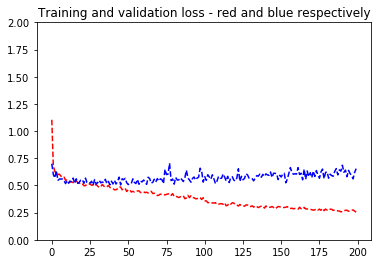

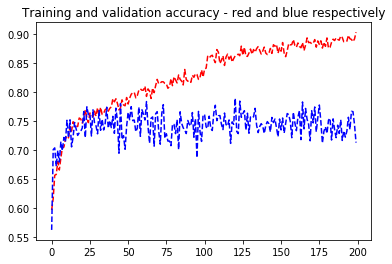

done


In [5]:
saved_dir = '../saved/IMPRS_hdf5_sumproj_mask/0628_194432'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir, best=False) #imported from utils

print('done')

In [6]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    #print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    #classes = ('endothelium', 'pct', 'vasculature')
    classes = ('endothelium', 'pct')
    all_pred = []
    all_true = []
    #hm_layers = {'final_layer': 'layer', 'fc_layer': 'fc_layer', 'conv_num': 17, 'fc_num': 3}
    
    #heatmapper = classActivationMap.CAMgenerator(hm_layers, config, model)
    #heatmapper.generateImage(num_images=10)
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            image = np.squeeze(data[0].cpu().data.numpy())
            label = np.squeeze(target[0].cpu().data.numpy())
            all_true.extend(target.cpu().data.numpy())
            all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
            
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 2:
                print("prediction percentages")
                print(output.cpu().data.numpy()[0])
                print(all_true[i])
                #util.visualizationOutGray(data, output, target, classes, normalized)
                a=1
                
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        #plt.show()
        
    
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    log['classes'] = classes
    log['test_targets'] = all_true
    log['test_predictions'] = all_pred
    print("My_metric is accuracy")
    util.plot_confusion_matrix(all_true, all_pred, classes=classes, normalize=False) 
    


In [7]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


Tesla K80


  0%|          | 0/7 [00:00<?, ?it/s]/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 43%|████▎     | 3/7 [00:00<00:00,  7.81it/s]

prediction percentages
[-1.5144955   0.66540563]
0
prediction percentages
[ 0.35480547 -0.8281818 ]
0


100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


num test images = 418
loss = 0.5878
my_metric = 0.7010
f1 = 0.7467
balanced_accuracy = 0.7128
precision = 0.8408
recall = 0.7010
My_metric is accuracy
Confusion matrix, without normalization
[[103  32]
 [ 93 190]]


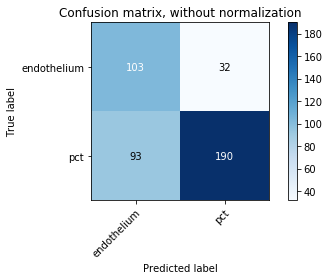

In [8]:
#Test
main2(config, resume)
